# 02b: Exploratory Data Analysis (Time Series)

## Project Overview
This notebook is part of the AAI590 Capstone Project, focusing on the analysis of time series data on the ICU Mortality dataset. This dataset contains information about patients in the ICU, including diagnoses, and outcomes. 

# Goal of the Notebook
The goal of this notebook is to perform exploratory data analysis (EDA) on the time series data. The analysis will include visualizations and statistical summaries to understand the trends and patterns in the data.

# 1. Imports and Config

Purpose: This section imports the necessary libraries and modules for EDA and sets up the configuration for the notebook and set plotting and display options

```python

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from scipy.stats import skew
import math
import pickle


# Plotting options
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 2. Setup and Data Loading

We Start by importing the data from the tensors created in the 01_Data_Ingestion.ipynb notebook, static data from the processed directory and outcomes from the Outcomes-a.txt file. 

```python

In [2]:
def read_patient_dynamic_tensors_df():
    file_path = '../data/processed/patient_dynamic_tensors_df.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        return df
    else:
        raise FileNotFoundError(f"File {file_path} does not exist.")


# invoke the function to read the DataFrame
dynamic_features_df = read_patient_dynamic_tensors_df()

# top 5 rows
dynamic_features_df.head()

,RecordID,Minutes,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,...,Platelets,RespRate,SaO2,SysABP,Temp,TroponinI,TroponinT,Urine,WBC,pH
0,137763,32,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,35.9,-1.0,-1.0,-1.0,-1.0,-1.0
1,137763,57,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,137763,62,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,137763,92,229.0,5.0,22.0,2.9,15.0,0.8,-1.0,0.5,...,112.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.6,-1.0
4,137763,122,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


# Feature Description

| **Field**     | **Type**   | **Description** |
|---------------|------------|-----------------|
| `RecordID`    | int64      | Unique identifier for each patient record. |
| `Minutes`     | int64      | Time in minutes when the event occured|
| `ALP`         | float64    | Alkaline Phosphatase, a liver enzyme used to assess liver or bile duct obstruction. |
| `ALT`         | float64    | Alanine Aminotransferase, elevated in liver damage or inflammation. |
| `AST`         | float64    | Aspartate Aminotransferase, associated with liver, heart, or muscle injury. |
| `Albumin`     | float64    | Protein made by the liver; low levels indicate poor liver/kidney function or malnutrition. |
| `BUN`         | float64    | Blood Urea Nitrogen, used to assess kidney function. |
| `Bilirubin`   | float64    | Indicates liver function and red blood cell breakdown. |
| `Cholesterol` | float64    | May be relevant to cardiovascular risk, though less critical in ICU setting. |
| `Creatinine`  | float64    | Reflects kidney function; elevated in renal impairment. |
| `DiasABP`     | float64    | Diastolic arterial blood pressure; low values may indicate shock or organ failure. |
| `FiO2`        | float64    | Fraction of inspired oxygen; indicates oxygen therapy levels. |
| `GCS`         | float64    | Glasgow Coma Scale; assesses neurological status. |
| `Glucose`     | float64    | Blood sugar; abnormalities common in critically ill patients. |
| `HCO3`        | float64    | Bicarbonate; reflects acid-base balance. |
| `HCT`         | float64    | Hematocrit; used to assess anemia or fluid status. |
| `HR`          | float64    | Heart Rate; vital for assessing cardiac stress. |
| `K`           | float64    | Potassium; important for cardiac function. |
| `Lactate`     | float64    | Elevated in hypoxia or sepsis, a marker of poor prognosis. |
| `MAP`         | float64    | Mean arterial pressure; key hemodynamic indicator. |
| `MechVent`    | float64    | Binary indicator if mechanical ventilation is used. |
| `Mg`          | float64    | Magnesium; relevant in cardiac and neuromuscular function. |
| `NIDiasABP`   | float64    | Non-invasive diastolic blood pressure. |
| `NIMAP`       | float64    | Non-invasive mean arterial pressure. |
| `NISysABP`    | float64    | Non-invasive systolic blood pressure. |
| `Na`          | float64    | Sodium; critical for fluid balance and brain function. |
| `PaCO2`       | float64    | Partial pressure of carbon dioxide; used to assess ventilation status. |
| `PaO2`        | float64    | Partial pressure of oxygen; used to assess oxygenation. |
| `Platelets`   | float64    | Blood clotting cells; abnormal levels linked to bleeding or clotting risks. |
| `RespRate`    | float64    | Respiratory rate; elevated in stress or acidosis. |
| `SaO2`        | float64    | Oxygen saturation; indicates blood oxygenation. |
| `SysABP`      | float64    | Systolic arterial blood pressure. |
| `Temp`        | float64    | Temperature; elevated in infection, lowered in shock. |
| `TroponinI`   | float64    | Cardiac enzyme; elevated in myocardial injury. |
| `TroponinT`   | float64    | Another marker of cardiac injury. |
| `Urine`       | float64    | Urine output; proxy for kidney perfusion and function. |
| `WBC`         | float64    | White blood cell count; elevated in infection or inflammation. |
| `pH`          | float64    | Blood pH; reflects acid-base status. |


| **Theme**                    | **Features**                                                                                 | **Mortality Relevance** |
|-----------------------------|----------------------------------------------------------------------------------------------|--------------------------|
| **Demographics / Metadata** | `RecordID`, `Minutes`                                                                        | ⚠️ Used for indexing/time |
| **Cardiovascular (Hemodynamic)** | `HR`, `SysABP`, `DiasABP`, `MAP`, `NISysABP`, `NIDiasABP`, `NIMAP`, `MechVent`               | ✔️ High                   |
| **Respiratory / Pulmonary** | `RespRate`, `SaO2`, `FiO2`, `PaO2`, `PaCO2`                                                  | ✔️ High                   |
| **Renal Function**          | `Creatinine`, `BUN`, `Urine`                                                                 | ✔️ High                   |
| **Liver Function**          | `ALT`, `AST`, `ALP`, `Albumin`, `Bilirubin`                                                  | ⚠️ Medium                 |
| **Metabolic / Electrolytes**| `Na`, `K`, `Mg`, `Glucose`, `Lactate`, `HCO3`, `pH`                                          | ✔️ High                   |
| **Hematologic / Coagulation** | `HCT`, `Platelets`, `WBC`, `TroponinI`, `TroponinT`                                          | ⚠️ Medium                 |
| **Neurological**            | `GCS`                                                                                        | ✔️ High                   |
| **Other Vitals**            | `Temp`, `Cholesterol`                                                                        | ⚠️ Low                    |

✔️ = Strongly associated with ICU mortality prediction  
⚠️ = Useful but context-dependent or less predictive on its own


In [3]:
dynamic_features_df.dtypes

RecordID         int64
Minutes          int64
ALP            float64
ALT            float64
AST            float64
Albumin        float64
BUN            float64
Bilirubin      float64
Cholesterol    float64
Creatinine     float64
DiasABP        float64
FiO2           float64
GCS            float64
Glucose        float64
HCO3           float64
HCT            float64
HR             float64
K              float64
Lactate        float64
MAP            float64
MechVent       float64
Mg             float64
NIDiasABP      float64
NIMAP          float64
NISysABP       float64
Na             float64
PaCO2          float64
PaO2           float64
Platelets      float64
RespRate       float64
SaO2           float64
SysABP         float64
Temp           float64
TroponinI      float64
TroponinT      float64
Urine          float64
WBC            float64
pH             float64
dtype: object

In [4]:
# Shape of the DataFrame
print('Shape of the DataFrame:', dynamic_features_df.shape)

Shape of the DataFrame: (295354, 38)


In [5]:
# Read static data
static_file_path = r'../data/processed/patient_static_data_df.csv'

# Load the static data into a DataFrame
df_static = pd.read_csv(static_file_path)

# Display the first few rows of the static data
df_static.head()

,RecordID,Age,Gender,Height,ICUType,In-hospital_death,Length_of_stay,SAPS-I,SOFA,Survival,Weight
0,137763,52.0,1.0,185.4,1.0,0,8,9,2,1130,90.0
1,137035,65.0,1.0,-1.0,2.0,1,14,11,3,13,-1.0
2,135275,47.0,0.0,-1.0,1.0,0,3,4,1,10,86.6
3,138905,35.0,0.0,154.9,2.0,0,6,-1,7,-1,67.0
4,141424,64.0,0.0,-1.0,3.0,1,14,-1,-1,14,74.3


In [6]:
# Load outcomes
outcomes_path = r'../data/raw/Outcomes-a.txt'
outcomes_df = pd.read_csv(outcomes_path)
outcomes_df.set_index('RecordID', inplace=True)


# From outcomes
outcome_static_features = set(outcomes_df.columns) - {'RecordID'}
static_params = ['RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'Weight']
# Combine static features with outcomes
static_params += list(outcome_static_features)


#  3. Intial Schema Analysis

Purpose: This section performs an initial schema analysis of the data, including checking the data types
```python

In [7]:
# Display the schema and shape of the static data
print("Static Data Schema:")
print(df_static.dtypes)
print("\nStatic Data Shape:", df_static.shape)


# Display the schema and shape of the outcomes data
print("\nOutcomes Data Schema:")
print(outcomes_df.dtypes)
print("\nOutcomes Data Shape:", outcomes_df.shape)


# Display the schema and shape of dynamic data
print("\nDynamic Data Schema")
print(dynamic_features_df.dtypes)
print("\Dynamic Data Shape:", dynamic_features_df.shape)

Static Data Schema:
RecordID               int64
Age                  float64
Gender               float64
Height               float64
ICUType              float64
In-hospital_death      int64
Length_of_stay         int64
SAPS-I                 int64
SOFA                   int64
Survival               int64
Weight               float64
dtype: object

Static Data Shape: (4000, 11)

Outcomes Data Schema:
SAPS-I               int64
SOFA                 int64
Length_of_stay       int64
Survival             int64
In-hospital_death    int64
dtype: object

Outcomes Data Shape: (4000, 5)

Dynamic Data Schema
RecordID         int64
Minutes          int64
ALP            float64
ALT            float64
AST            float64
Albumin        float64
BUN            float64
Bilirubin      float64
Cholesterol    float64
Creatinine     float64
DiasABP        float64
FiO2           float64
GCS            float64
Glucose        float64
HCO3           float64
HCT            float64
HR             float64


<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
C:\Users\jegullin\AppData\Local\Temp\ipykernel_19568\1882883980.py:16: SyntaxWarning: invalid escape sequence '\D'
  print("\Dynamic Data Shape:", dynamic_features_df.shape)


In [8]:
# describe the static data
print("\nStatic Data Description:")
df_static.describe()


Static Data Description:


,RecordID,Age,Gender,Height,ICUType,In-hospital_death,Length_of_stay,SAPS-I,SOFA,Survival,Weight
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000
mean,137605.122000,64.247500,0.560750,88.919475,2.760000,0.138500,13.441750,14.203500,6.402500,128.735500,74.75629
std,2923.608886,17.560946,0.497867,86.531203,1.002572,0.345467,12.246371,6.088584,4.201298,363.714273,31.97107
min,132539.000000,15.000000,-1.000000,-1.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000
25%,135075.750000,52.750000,0.000000,-1.000000,2.000000,0.000000,6.000000,11.000000,3.000000,-1.000000,62.00000
50%,137592.500000,67.000000,1.000000,152.400000,3.000000,0.000000,10.000000,15.000000,6.000000,-1.000000,76.20000
75%,140100.250000,78.000000,1.000000,170.200000,4.000000,0.000000,17.000000,18.000000,9.000000,16.000000,90.42500
max,142673.000000,90.000000,1.000000,431.800000,4.000000,1.000000,154.000000,34.000000,22.000000,2600.000000,300.00000


In [9]:
# describe the outcomes data
print("\nOutcomes Data Description:")
outcomes_df.describe()



Outcomes Data Description:


,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,14.203500,6.402500,13.441750,128.735500,0.138500
std,6.088584,4.201298,12.246371,363.714273,0.345467
min,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,11.000000,3.000000,6.000000,-1.000000,0.000000
50%,15.000000,6.000000,10.000000,-1.000000,0.000000
75%,18.000000,9.000000,17.000000,16.000000,0.000000
max,34.000000,22.000000,154.000000,2600.000000,1.000000


In [10]:
# describe the dynamic data
print("\nDynamic Data Description:")
dynamic_features_df.describe()


Dynamic Data Description:


,RecordID,Minutes,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,...,Platelets,RespRate,SaO2,SysABP,Temp,TroponinI,TroponinT,Urine,WBC,pH
count,295354.000000,295354.000000,295354.000000,295354.000000,295354.000000,295354.000000,295354.000000,295354.000000,295354.000000,295354.000000,...,295354.000000,295354.000000,295354.000000,295354.000000,295354.000000,295354.000000,295354.000000,295354.000000,295354.000000,295354.000000
mean,137611.386391,1312.449799,0.231942,3.252768,4.464565,-0.968727,0.337975,-0.957776,-0.832005,-0.881463,...,8.153487,2.862182,1.705768,58.027469,10.097795,-0.987995,-0.984186,54.257099,-0.402974,-0.299977
std,2918.524886,845.794497,18.198737,130.969178,165.858666,0.353647,7.874517,0.734750,5.356330,0.640015,...,47.032256,8.418399,16.036936,62.368616,17.308123,0.487751,0.295870,135.700771,3.217991,3.325184
min,132539.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-17.800000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,135086.000000,546.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,137624.000000,1250.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,140104.000000,2039.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,116.000000,36.200000,-1.000000,-1.000000,60.000000,-1.000000,-1.000000
max,142673.000000,2880.000000,2205.000000,11470.000000,18430.000000,5.300000,197.000000,47.700000,330.000000,22.100000,...,1047.000000,98.000000,100.000000,295.000000,42.100000,49.200000,24.910000,11000.000000,187.500000,735.000000


# 4. Missing Values Analysis

Purpose: This section checks for missing values in the data and provides a summary of the missing values in each column.
```python

### Findings: Missing Values in Dynamic Features (4,000 Patients)

1. Many features have missing values for **more than 95%** of patients:

     * `ALP`, `ALT`, `AST`, `Albumin`, `BUN`, `Bilirubin`, `Cholesterol`, `DiasABP`, `HCO3`, `Lactate`, `Na`, `PaCO2`, `PaO2`, `SaO2`, `SysABP`, `TroponinI`, `TroponinT`, `WBC`, `pH`
   * These are likely **incomplete across time** and might be **non-routinely measured or conditionally recorded**.

2. Features like `FiO2`, `GCS`, `Creatinine`, `Glucose`, `HR`, `K`, `MAP`, `Mg`, `Platelets`, `RespRate`, `Temp` have **moderate missingness (\~60%–90%)**.
   * These features may be valuable but require **targeted imputation strategies**.

3. Some features show **high completeness (>90%)**:

     * `MechVent`, `NIDiasABP`, `NIMAP`, `NISysABP`, `Urine`
   * These are strong candidates for early model training and robust statistical analysis.





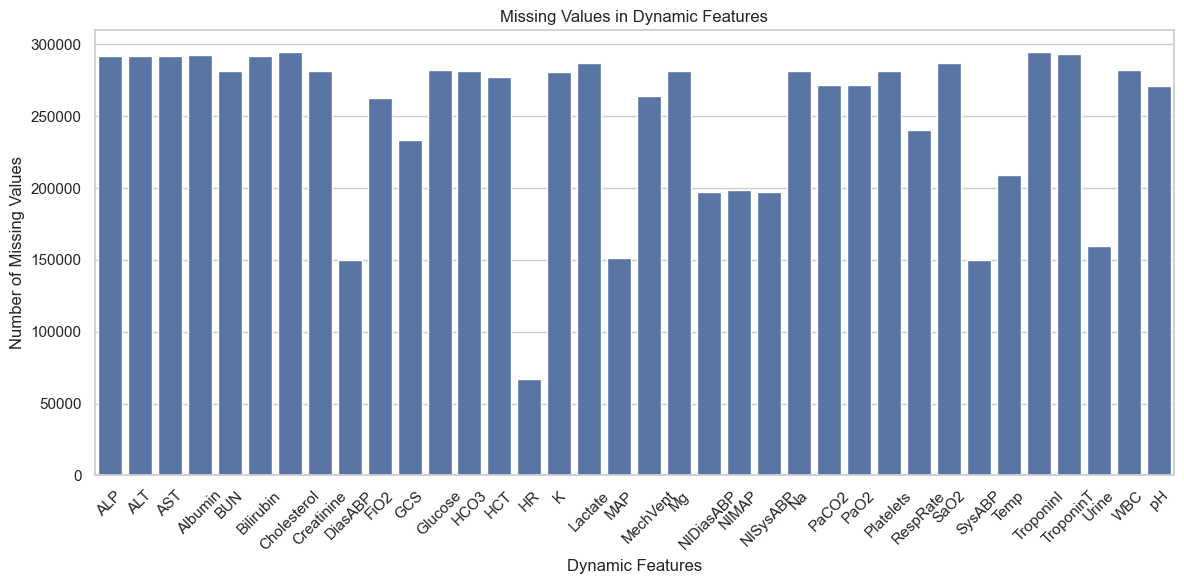

In [11]:
# Missing Values Visualization Analysis 
dynamics_columns = dynamic_features_df[dynamic_features_df.columns[dynamic_features_df.isin([-1]).any()]].columns

# Plot missing values in dynamic features
plt.figure(figsize=(12, 6))
sns.barplot(x=dynamics_columns, y=dynamic_features_df[dynamics_columns].isin([-1]).sum().values)
plt.title('Missing Values in Dynamic Features')
plt.xlabel('Dynamic Features')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Findings by Theme

Metabolic / Electrolyte features (e.g., Na, K, Mg, pH) have the highest missingness. This makes clinical sense as these labs may be ordered less frequently unless specific metabolic concerns are present.

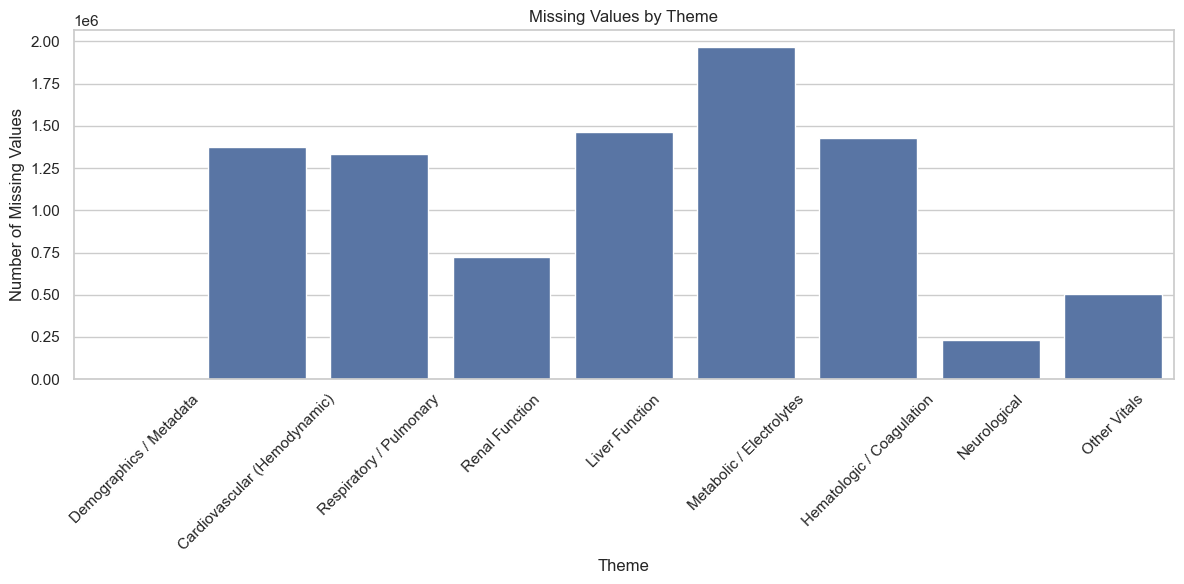

In [12]:

# Missing values by Theme 

themes = {
    "Demographics / Metadata": ['RecordID', 'Minutes'],
    "Cardiovascular (Hemodynamic)": ['HR', 'SysABP', 'DiasABP', 'MAP', 'NISysABP', 'NIDiasABP', 'NIMAP', 'MechVent'],
    "Respiratory / Pulmonary": ['RespRate', 'SaO2', 'FiO2', 'PaO2', 'PaCO2'],
    "Renal Function": ['Creatinine', 'BUN', 'Urine'],
    "Liver Function": ['ALT', 'AST', 'ALP', 'Albumin', 'Bilirubin'],
    "Metabolic / Electrolytes": ['Na', 'K', 'Mg', 'Glucose', 'Lactate', 'HCO3', 'pH'],
    "Hematologic / Coagulation": ['HCT', 'Platelets', 'WBC', 'TroponinI', 'TroponinT'],
    "Neurological": ['GCS'],
    "Other Vitals": ['Temp', 'Cholesterol']
}

# Calculate missing values by theme
missing_values_by_theme = {theme: dynamic_features_df[features].isin([-1]).sum().sum() for theme, features in themes.items()}
# Plot missing values by theme
plt.figure(figsize=(12, 6))
sns.barplot(x=list(missing_values_by_theme.keys()), y=list(missing_values_by_theme.values()))
plt.title('Missing Values by Theme')
plt.xlabel('Theme')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 5. Univariate Analysis

Purpose: The goal is to check distributions of individual features 

```python

##  Findings

* **BUN, Creatinine, Glucose, HCO3, HCT, K, Mg, Na, Platelets, WBC**
  → Extremely peaked or sparse distributions suggest **defaulted, missing, or imputed values**.

* **GCS**
  → Strong spike at value **15**, possibly indicating most patients were fully alert or that **imputation** was used.

* **HR, NIDiasABP, NIMAP, NISysABP, RespRate**
  → These features show **naturally varying distributions**, indicating genuine physiological variability.


* **Urine Output**
  → **Right-skewed distribution**, possibly reflecting patients under **interventions (e.g., diuretics)** or outliers.

---

##  Actionable Insights

* Features with sharp single-value peaks (e.g., **GCS = 15**, **WBC**) should be audited or **flagged as categorical "defaulted"**.

* **log or quantile transformation** on features like **Glucose, Urine, Platelets** for better model input scaling.

* Features with near-constant values (e.g., **Mg, HCO3**) may be **non-informative for prediction** and could be excluded.

* features like **HR, BP metrics, Temp** directly for modeling, as they demonstrate good distribution characteristics.



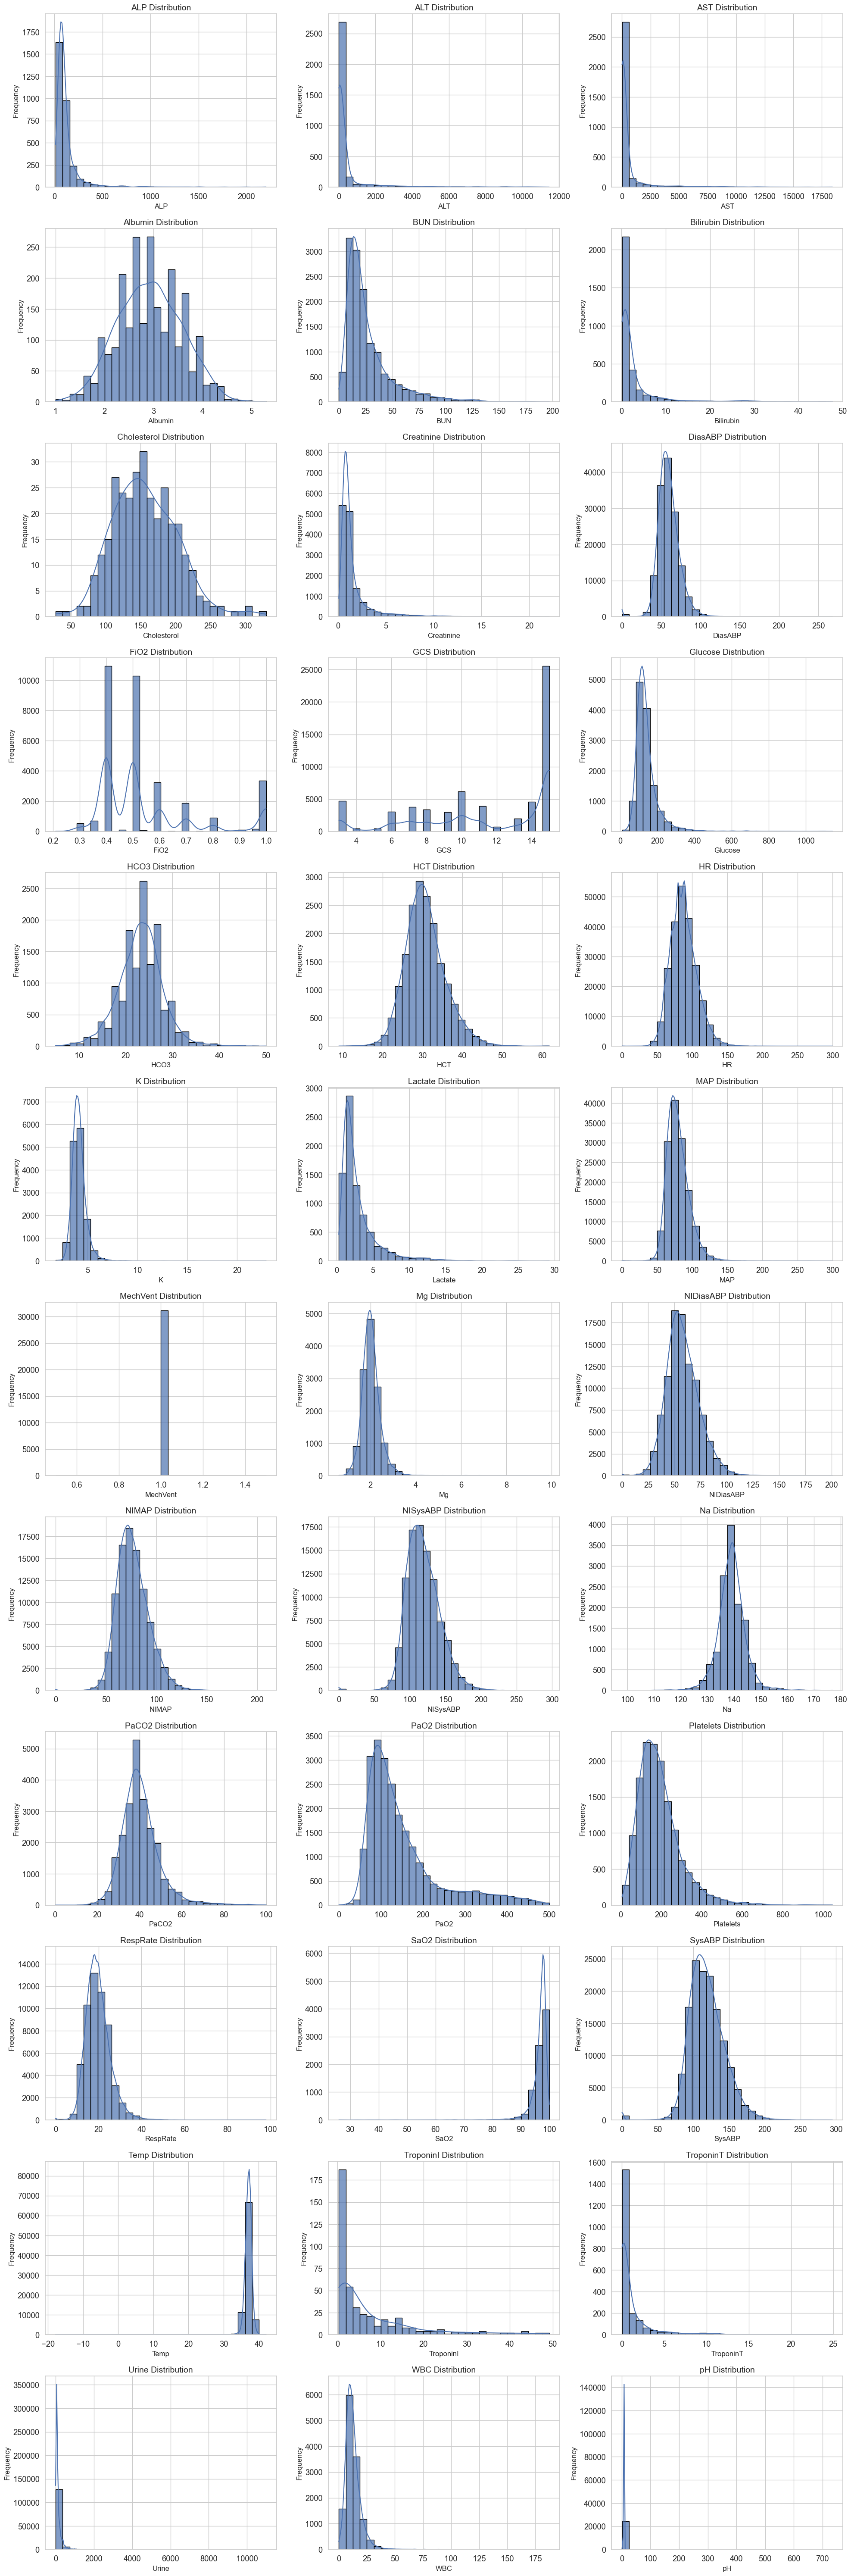

In [13]:
sns.set(style='whitegrid', font_scale=1.2)

# Identify valid columns 
valid_columns = []
for column in dynamics_columns:
    data = dynamic_features_df[column]
    if len(data.dropna()) >= 5 and data.nunique() > 1 and data.var() > 0:
        valid_columns.append(column)

# Layout configuration
num_cols = 3
num_rows = math.ceil(len(valid_columns) / num_cols)
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows * 5))
axes = axes.flatten()

# Plot each feature excluding -1 values
for i, column in enumerate(valid_columns):
    ax = axes[i]
    
    # Filter out -1 and NaN
    valid_data = dynamic_features_df[column]
    valid_data = valid_data[(valid_data != -1) & (~valid_data.isna())]

    sns.histplot(
        valid_data,
        bins=30,
        kde=True,
        ax=ax,
        edgecolor='black',
        alpha=0.7
    )
    ax.set_title(f'{column} Distribution', fontsize=14)
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

# Remove any unused axes
for j in range(len(valid_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


###  Findings from Static Feature Distributions

1. **Age Distribution**
   - The dataset is skewed toward older patients, with a majority between **60–90 years**.
   - Suggests an elderly ICU population, which may influence outcomes like mortality or length of stay.

2. **Gender**
   - Binary distribution with clear separation; the values `0` and `1` likely represent **female and male**.
   - Gender balance appears roughly even, indicating minimal demographic bias.

3. **Height and Weight**
   - **Height** shows a bimodal distribution, possibly due to recording inconsistencies (e.g., inches vs. cm or padding/missing values).
   - **Weight** is right-skewed with a heavy cluster around **60–80 kg**, which is expected in clinical populations. Some patients appear underweight or obese.

4. **ICUType**
   - Appears to be a categorical variable with 4 distinct types (likely mapped to units like MICU, SICU, etc.).
   - Distribution across types seems uneven but sufficiently diverse.

5. **In-hospital Death**
   - Clearly binary. Most patients survived (`0`), while a smaller group experienced mortality (`1`).
   - Indicates **class imbalance**, important for downstream classification models.

6. **Length of Stay**
   - Right-skewed: Most patients stay less than **20 days**, with a long tail extending to over **150 days**.
   - Outliers may need to be capped or log-transformed for modeling.

7. **SAPS-I and SOFA Scores**
   - Both severity scores show bell-shaped or uniform-like spread.
   - SAPS-I peaks around **15–20**, and SOFA around **5–10**, consistent with moderate severity populations.
   - Good candidates for feature importance analysis in outcome prediction.

8. **Survival (Time)**
   - Similar to Length of Stay — strongly right-skewed with a majority surviving under **500 days**.
   - May need transformation or capping to reduce influence of long-tail outliers.

---

### Actionable Insights:
- Consider **log-transforming**: `Length_of_stay`, `Survival`, `Weight`
- Handle **bimodality** in `Height` and possible unit inconsistencies
- Address **class imbalance** in `In-hospital_death` for supervised tasks
- Convert `Gender` and `ICUType` to categorical types for modeling
- `SAPS-I` and `SOFA` scores as strong baseline features for predictive models


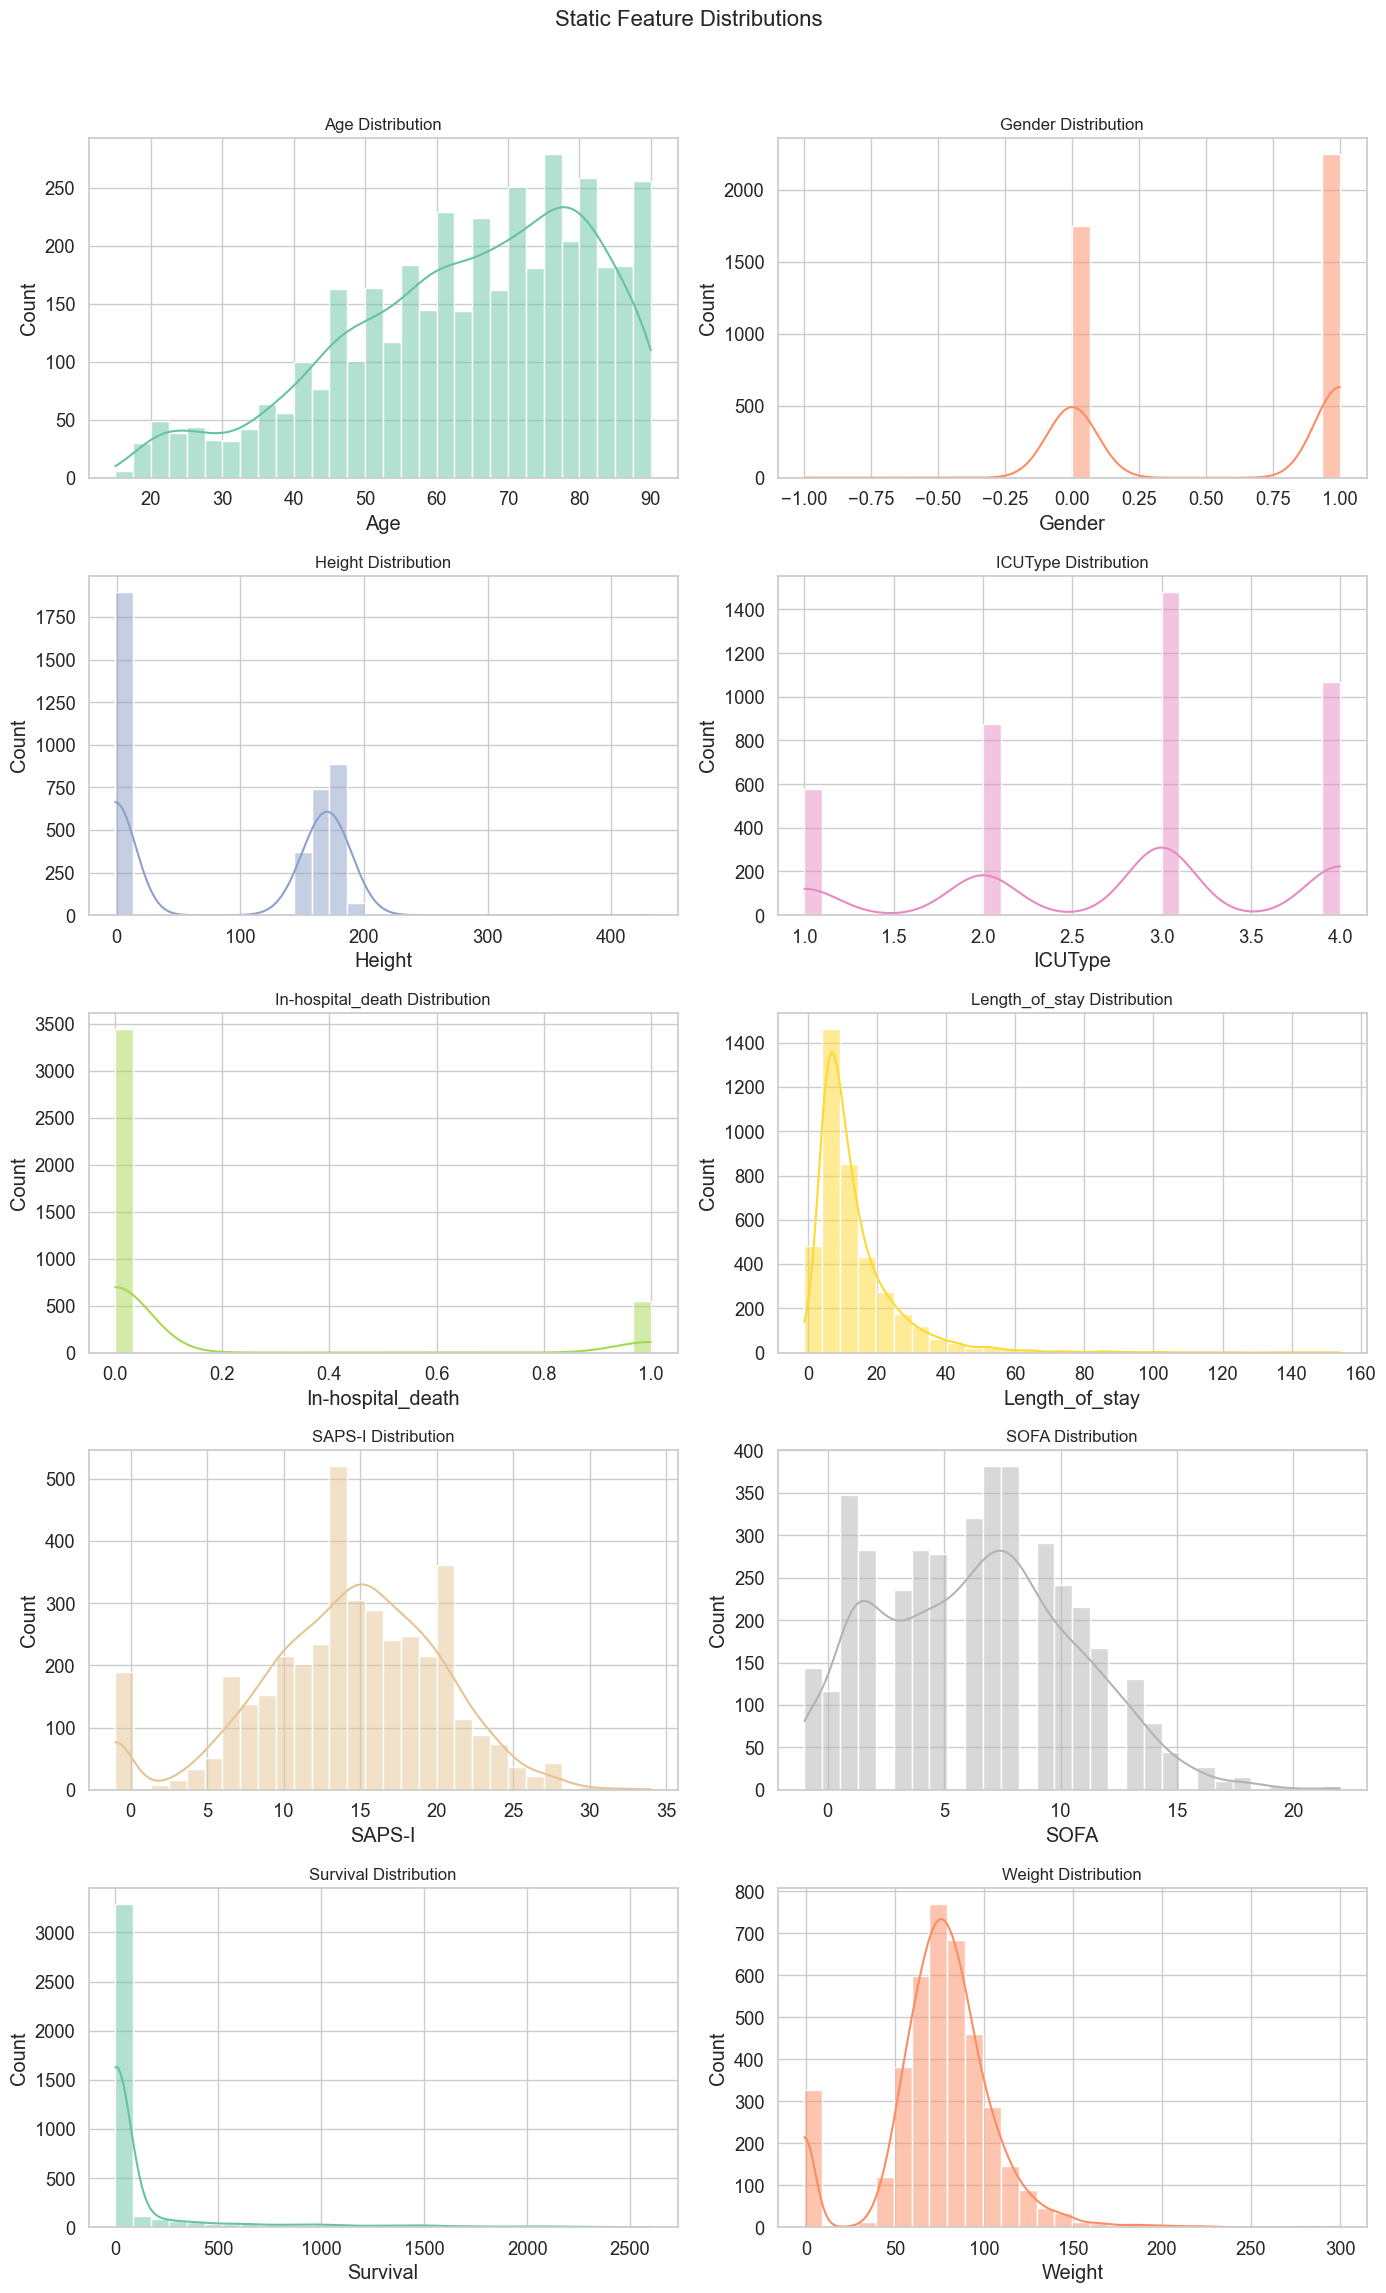

In [14]:
# Drop identifier
static_cols = df_static.columns.drop(['RecordID'])

# Layout
n_features = len(static_cols)
n_cols = 2
n_rows = math.ceil(n_features / n_cols)
num_palette = sns.color_palette("Set2")
cat_color = sns.color_palette("Pastel1")[2]  

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 4.5 * n_rows))
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(static_cols):
    ax = axes[i]
    
    if pd.api.types.is_numeric_dtype(df_static[feature]):
        color = num_palette[i % len(num_palette)]
        sns.histplot(df_static[feature], bins=30, kde=True, ax=ax, color=color)
        ax.set_ylabel('Count')
    else:
        sns.countplot(x=feature, data=df_static, ax=ax, color=cat_color)
        ax.set_ylabel('Frequency')
        ax.tick_params(axis='x', rotation=45)

    ax.set_title(f'{feature} Distribution', fontsize=12)
    ax.set_xlabel(feature)
    ax.grid(True)

# Hide any extra subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Static Feature Distributions", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


###  In-Hospital Mortality Distribution

1. **Survival Rate Dominates**  
   Out of **4,000 total patients**, **3,446 (86.2%)** survived their hospital stay, while **554 (13.9%)** died.  
   This reflects a strong survival majority in the cohort and is a key characteristic of the dataset.

2. **Class Imbalance is Significant**  
   The dataset is **highly imbalanced**, with the positive class (mortality) making up only ~14% of all patients.  
   This imbalance can bias models toward predicting survival unless properly addressed.

3. **Clinical Realism Maintained**  
   The observed mortality rate (~14%) is within expected bounds for typical ICU cohorts, indicating good data quality and clinical validity.

---

###  Actionable Insights

- Apply **resampling techniques** (e.g., SMOTE, undersampling) or **class weighting** in models to reduce bias against minority class.


C:\Users\jegullin\AppData\Local\Temp\ipykernel_19568\1119975794.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


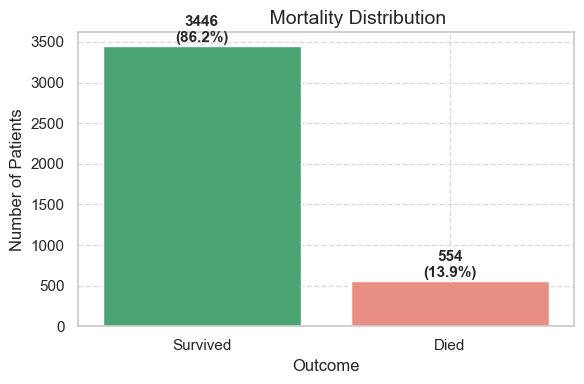

In [15]:
# Reset index
outcomes_plot_df = outcomes_df.reset_index()

# Map numeric values to readable labels
label_map = {0: 'Survived', 1: 'Died'}
outcomes_plot_df['In-hospital_death'] = outcomes_plot_df['In-hospital_death'].map(label_map)

# Count values
value_counts = outcomes_plot_df['In-hospital_death'].value_counts()
total = value_counts.sum()
percentages = (value_counts / total * 100).round(1)

# Plot
plt.figure(figsize=(6, 4))
sns.set(style="whitegrid")
ax = sns.countplot(
    x='In-hospital_death', 
    data=outcomes_plot_df, 
    palette=['mediumseagreen', 'salmon']
)

# Add percentage labels on top of bars
for p in ax.patches:
    height = p.get_height()
    label = p.get_x() + p.get_width() / 2
    count = int(height)
    pct = (height / total) * 100
    ax.annotate(f'{count}\n({pct:.1f}%)', 
                (label, height + 50), 
                ha='center', fontsize=11, fontweight='bold')


plt.title("            Mortality Distribution", fontsize=14)
plt.xlabel("Outcome", fontsize=12)
plt.ylabel("Number of Patients", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Findings: Mortality Rate by Age Group

1. **Clear Age-Dependent Risk Gradient**
   - Mortality rate increases steadily with age.
   - Patients aged **80+** have the highest mortality rate (~22%), while those **under 30** have the lowest (~6%).

2. **Transitional Risk Zones**
   - A noticeable mortality increase occurs after age **50**, with a sharper climb beyond **65 years**.
   - The groups **65–80** and **80+** show a distinct shift into higher-risk territory, suggesting age thresholds that may require tailored care.

3. **Younger Patients Show Better Outcomes**
   - Patients younger than 50 exhibit relatively low mortality risk, indicating resilience or fewer comorbidities at admission.

---

###  Actionable Insights

- Incorporate **age group features** into models for improved mortality prediction.
- Prioritize elderly patients (**65+**) for **early warning systems**, **closer monitoring**, and **resource allocation**.



C:\Users\jegullin\AppData\Local\Temp\ipykernel_19568\747864883.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
C:\Users\jegullin\AppData\Local\Temp\ipykernel_19568\747864883.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


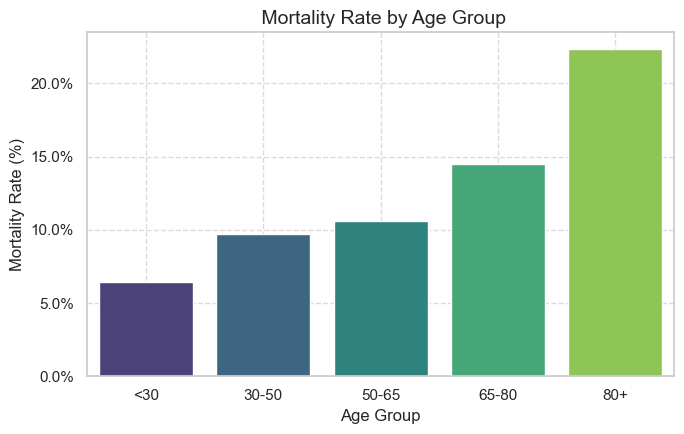

In [16]:
# Create age bins
bins = [0, 30, 50, 65, 80, 100]
labels = ['<30', '30-50', '50-65', '65-80', '80+']
mortality_by_age = df_static[['RecordID', 'Age']].copy()
mortality_by_age['AgeGroup'] = pd.cut(mortality_by_age['Age'], bins=bins, labels=labels)

# Merge with outcome
mortality_by_age = mortality_by_age.merge(outcomes_df.reset_index(), on='RecordID')

# Plot
plt.figure(figsize=(7, 4.5))
sns.set(style="whitegrid")
ax = sns.barplot(
    data=mortality_by_age,
    x='AgeGroup',
    y='In-hospital_death',
    ci=None,
    palette='viridis'
)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.title(" Mortality Rate by Age Group", fontsize=14)
plt.xlabel("Age Group")
plt.ylabel("Mortality Rate (%)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Index(['RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'In-hospital_death',
       'Length_of_stay', 'SAPS-I', 'SOFA', 'Survival', 'Weight', 'Minutes',
       'ALP', 'ALT', 'AST', 'Albumin', 'BUN', 'Bilirubin', 'Cholesterol',
       'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Glucose', 'HCO3', 'HCT', 'HR',
       'K', 'Lactate', 'MAP', 'MechVent', 'Mg', 'NIDiasABP', 'NIMAP',
       'NISysABP', 'Na', 'PaCO2', 'PaO2', 'Platelets', 'RespRate', 'SaO2',
       'SysABP', 'Temp', 'TroponinI', 'TroponinT', 'Urine', 'WBC', 'pH'],
      dtype='object')


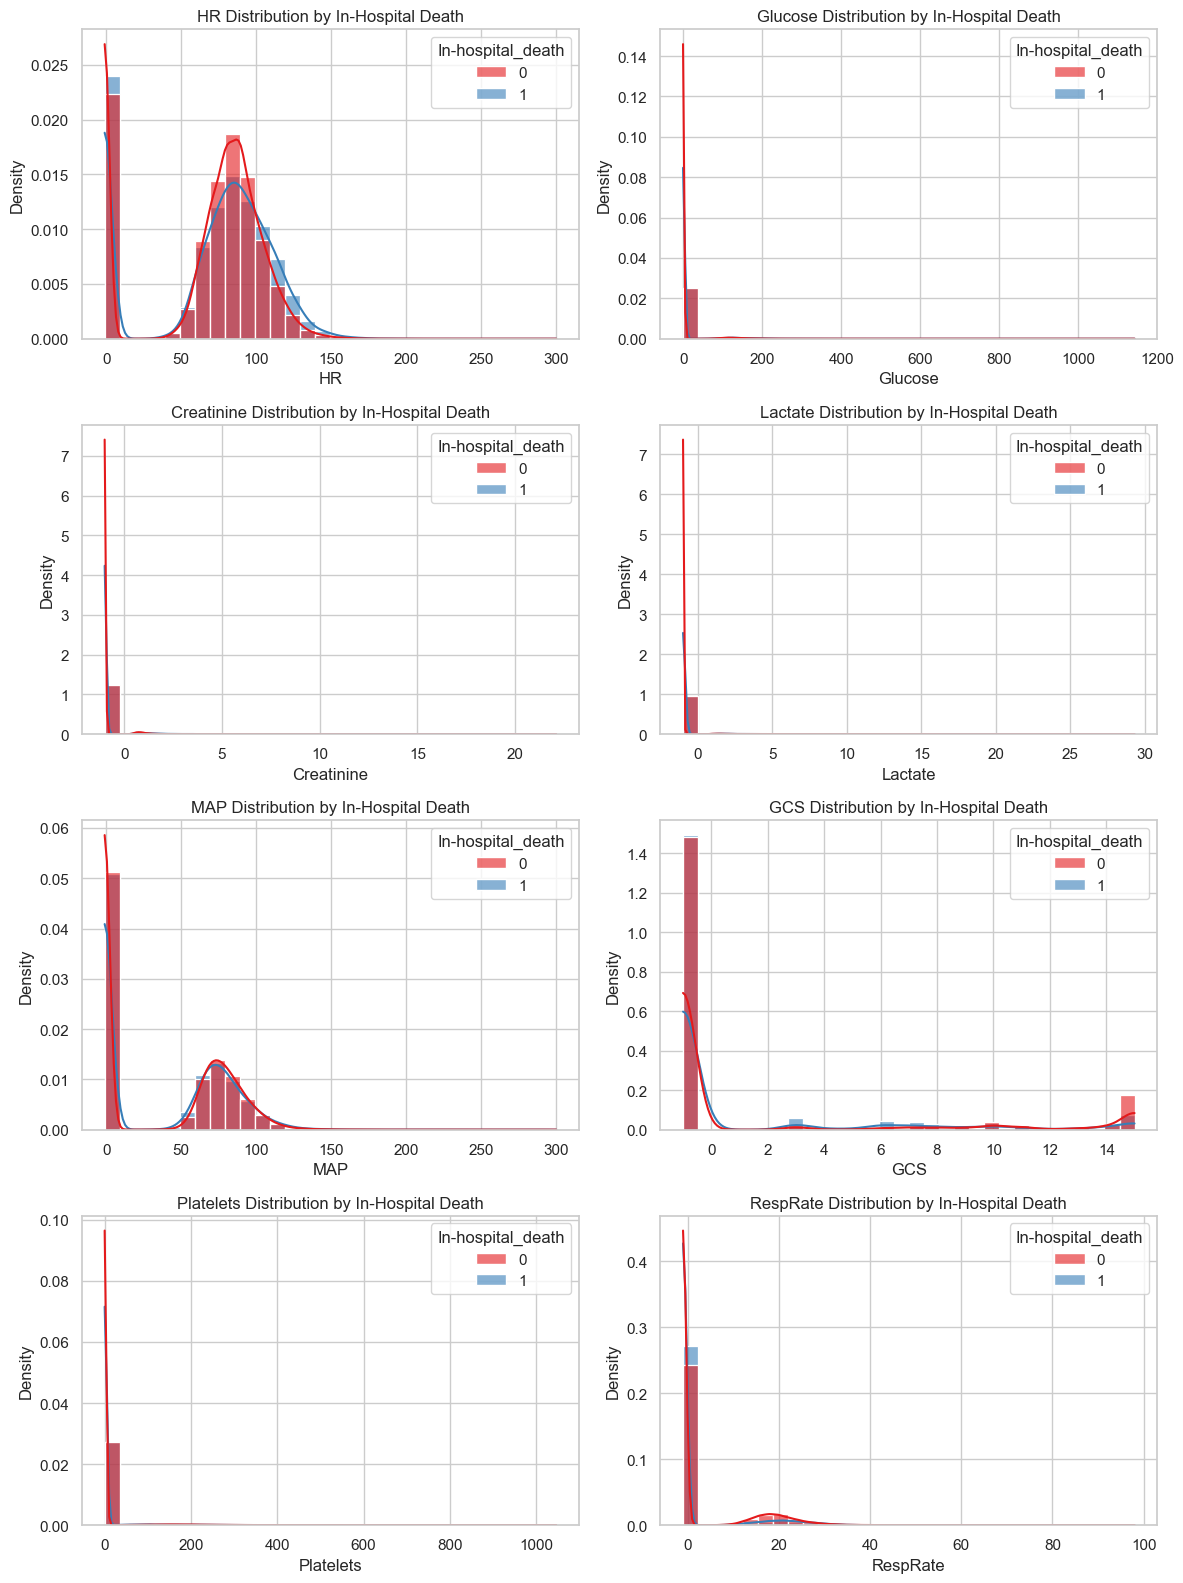

In [17]:
# Function to join static, dynamic, and outcomes datasets
def join_all_features(static_df, dynamic_df, outcomes_df):
    # Merge static and dynamic on RecordID
    combined_df = pd.merge(static_df, dynamic_df, on='RecordID', how='inner')
    
    # Merge with outcome data
    combined_df = pd.merge(combined_df, outcomes_df, on='RecordID', how='inner')
    
    return combined_df

# Join all features
combined_df = join_all_features(df_static, dynamic_features_df, outcomes_df)

# Drop redundant columns from outcome table (_y) and rename _x to original names
columns_to_drop = ['In-hospital_death_y', 'Length_of_stay_y', 'SAPS-I_y', 'SOFA_y', 'Survival_y']
combined_df.drop(columns=columns_to_drop, inplace=True)

combined_df.rename(columns={
    'In-hospital_death_x': 'In-hospital_death',
    'Length_of_stay_x': 'Length_of_stay',
    'SAPS-I_x': 'SAPS-I',
    'SOFA_x': 'SOFA',
    'Survival_x': 'Survival'
}, inplace=True)

# Show cleaned column names
print(combined_df.columns)

# Plot stacked histograms with KDE for selected dynamic features
selected_features = ['HR', 'Glucose', 'Creatinine', 'Lactate', 'MAP', 'GCS', 'Platelets', 'RespRate']
n_cols = 2
n_rows = (len(selected_features) + n_cols - 1) // n_cols

plt.figure(figsize=(12, 4 * n_rows))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data=combined_df, x=feature, hue='In-hospital_death', kde=True, 
                 stat='density', common_norm=False, palette='Set1', bins=30, alpha=0.6)
    plt.title(f"{feature} Distribution by In-Hospital Death")
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()


## 6. Bivariate and Multivariate Analysis





## Correlation Analysis of Static Features

###  Key Observations

1. **Low Overall Multicollinearity**
   - Most pairwise correlations between static features are weak, with absolute values < 0.3.
   - This suggests low redundancy, which is favorable for many machine learning models.

2. **SAPS-I and SOFA Are Moderately Correlated**
   - **SAPS-I** and **SOFA** scores show a **moderate positive correlation (0.63)**, reflecting their shared purpose in measuring patient severity.
   - Despite overlap, they may capture different clinical dimensions and can both be included in modeling with caution.

3. **Outcome Correlations**
   - **In-hospital_death** shows **weak positive correlation** with:
     - **SAPS-I (0.18)**
     - **SOFA (0.18)**
     - **Age (0.13)**
   - This indicates that higher severity scores and older age slightly increase mortality risk, though not strongly linearly.

4. **Non-Predictive Identifiers**
   - **RecordID** has no meaningful correlation with any variable, as expected. It should be excluded from modeling.

---

### Actionable Insights

- Target features like **SAPS-I, SOFA, and Age** may benefit from **feature scaling or transformations** before modeling.



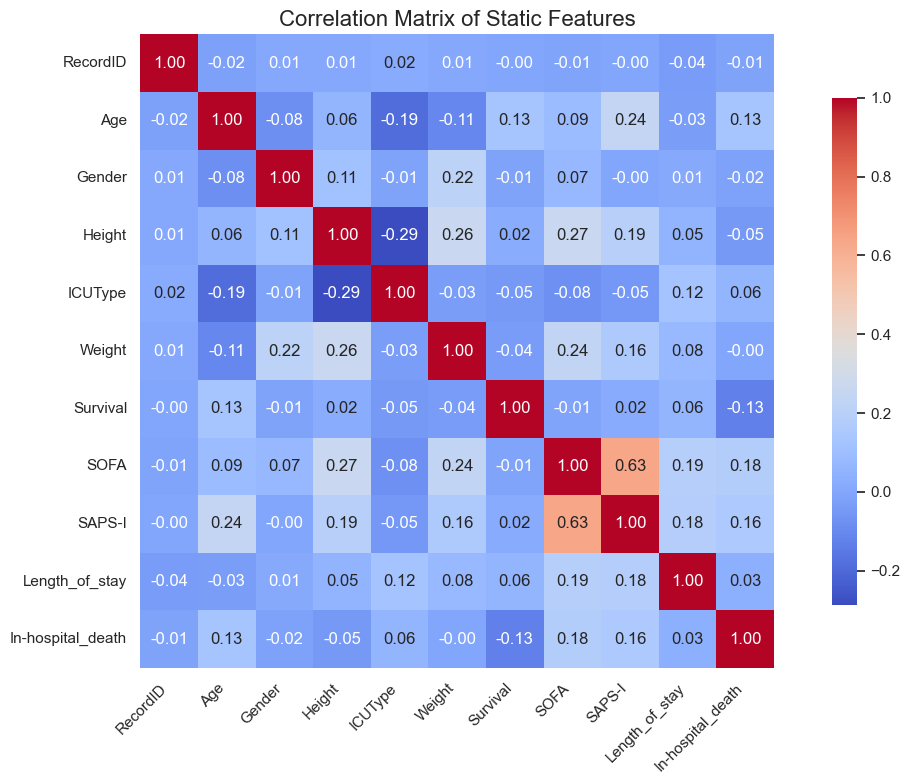

In [18]:
# Correlations of Static features
plt.figure(figsize=(12, 8))
correlation_matrix = df_static[static_params].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Static Features", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Selected Labs & Vitals Show Predictive Signal for Mortality
Features with weak-to-moderate correlation with In-hospital death include:

Low GCS (ρ ≈ -0.28)

Low Urine output (ρ ≈ -0.19)

High Lactate (ρ ≈ 0.25)

Elevated MAP and RespRate (ρ ≈ 0.1–0.2)

 Actionable Insight: These features are clinically aligned with poor outcomes and may be emphasized in model training or subgroup analysis.

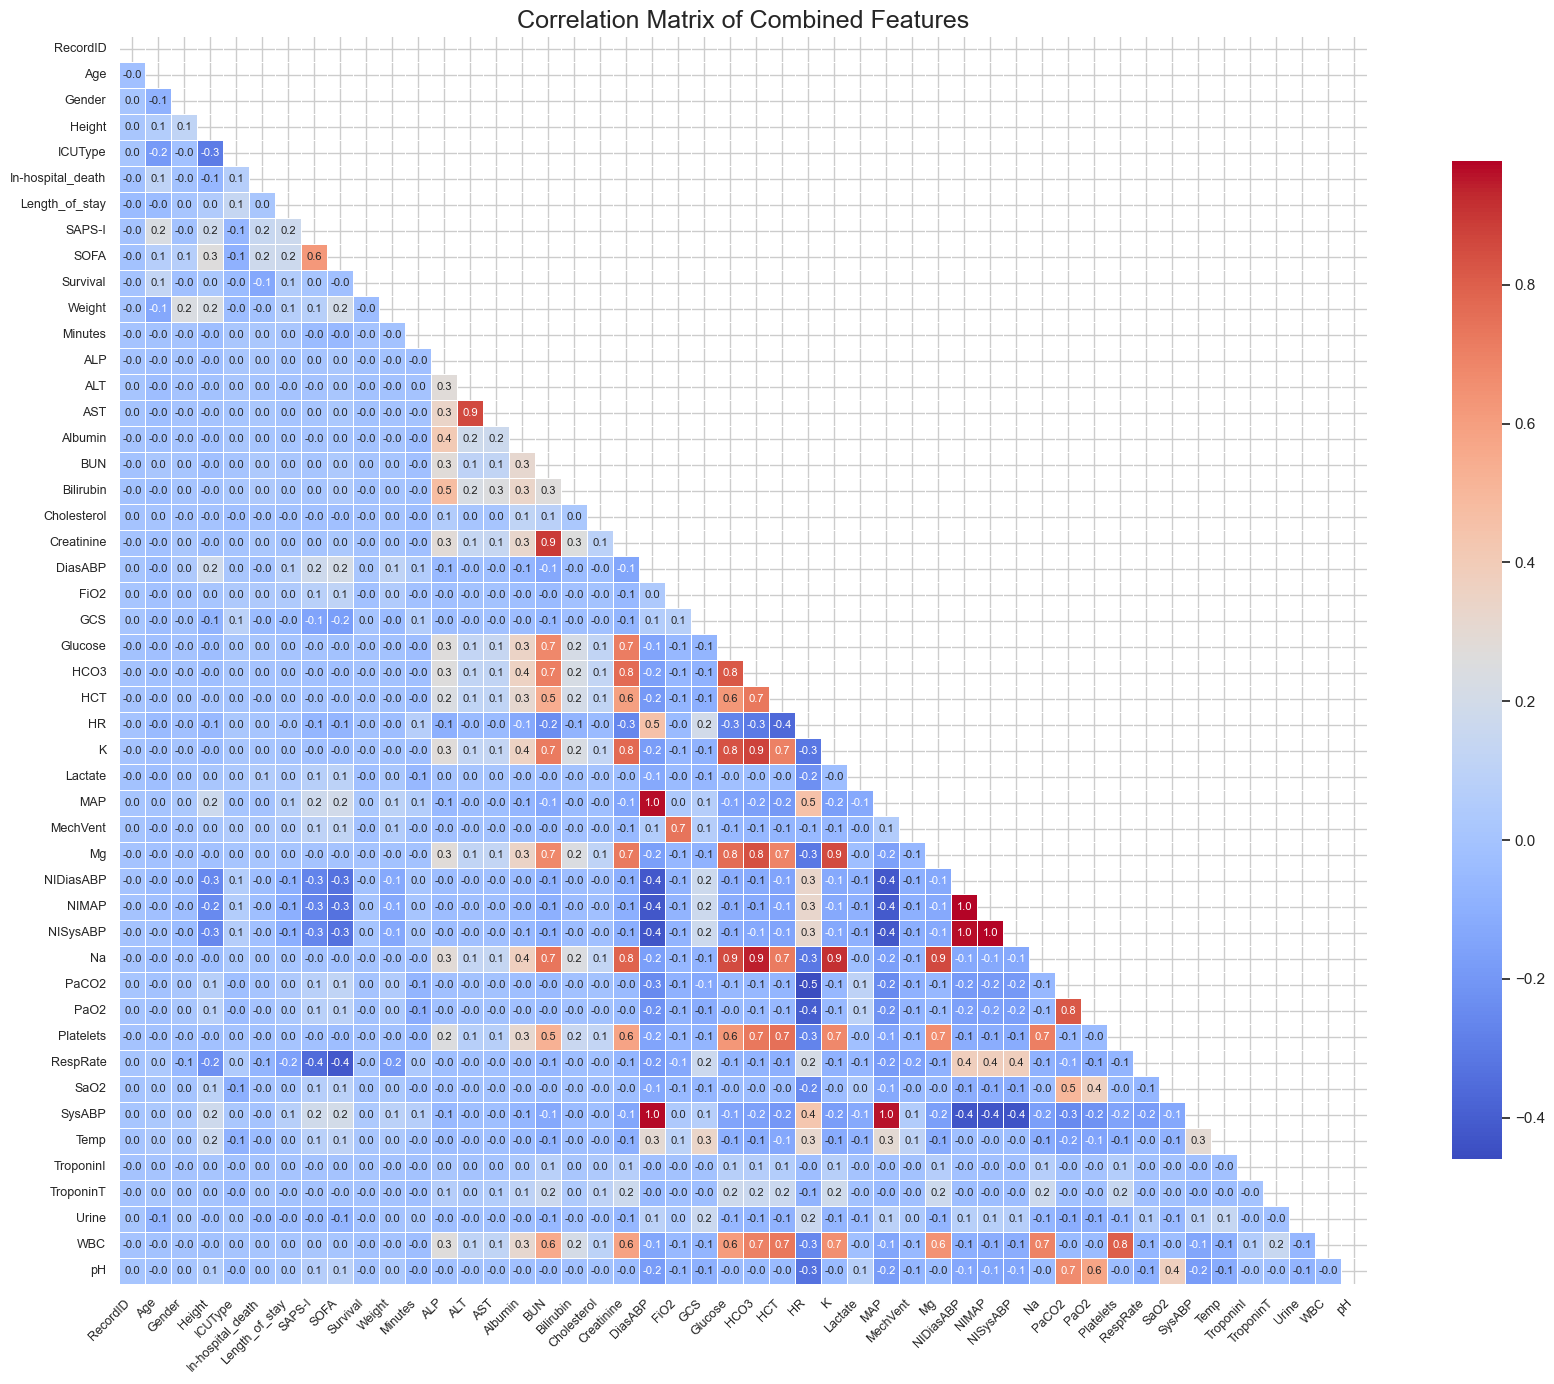

In [19]:
# Compute correlation matrix
combined_correlation_matrix = combined_df.corr()
mask = np.triu(np.ones_like(combined_correlation_matrix, dtype=bool))

# Plot
plt.figure(figsize=(18, 14))
sns.heatmap(
    combined_correlation_matrix,
    mask=mask,
    annot=True,
    fmt=".1f",
    cmap='coolwarm',
    square=True,
    linewidths=0.5,
    annot_kws={"size": 8},
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Matrix of Combined Features", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()


## Dynamic Features Correlation Analysis

##  Key Findings

| **Observation Area**                      | **Key Insight**                                                                                      |
|------------------------------------------|-------------------------------------------------------------------------------------------------------|
| **Hemodynamic Parameters**               | Strong positive correlations observed between **SysABP**, **DiasABP**, **MAP**, and **NIMAP** (r ≈ 0.81–0.89), consistent with their physiological interdependence. |
| **NIBP Subgroup Correlation**            | **NIDiasABP**, **NIMAP**, and **NISysABP** form a tight cluster (r > 0.80), indicating potential redundancy in modeling. |
| **SysABP & MAP**                         | Moderate to strong correlation (r ≈ 0.69), expected due to their derived relationship.                |
| **GCS & Other Features**                 | Glasgow Coma Scale (GCS) shows **no strong correlation** with other vitals, emphasizing its **distinctive role** in neurological assessment. |
| **Urine Output**                         | Very low correlations with all other variables, suggesting **orthogonal predictive value** (e.g., renal function). |
| **Temperature & Respiratory Rate**       | Weak correlations, supporting their **independent temporal dynamics**.                                |

---

##  Actionable Insights for Modeling

| **Recommendation**                                | **Rationale**                                                                                         |
|---------------------------------------------------|--------------------------------------------------------------------------------------------------------|
| **Dimensionality Reduction / Feature Selection**  |  dropping or compressing highly correlated features (e.g., NISysABP vs SysABP) to reduce multicollinearity, especially for models like XGBoost. |
| **Retain GCS and Urine in Sequence Models**       | Despite low correlation with other features, their domain importance justifies their inclusion in Transformer/CNN pipelines. |
| **Cluster-Aware Feature Engineering**             | Group blood pressure variables into an engineered "Hemodynamic Index" to simplify model input.         |
| **Model Interpretability Caution**                | Be cautious when interpreting feature importance scores from correlated features (e.g., SHAP), as importance may shift between highly collinear inputs. |

---



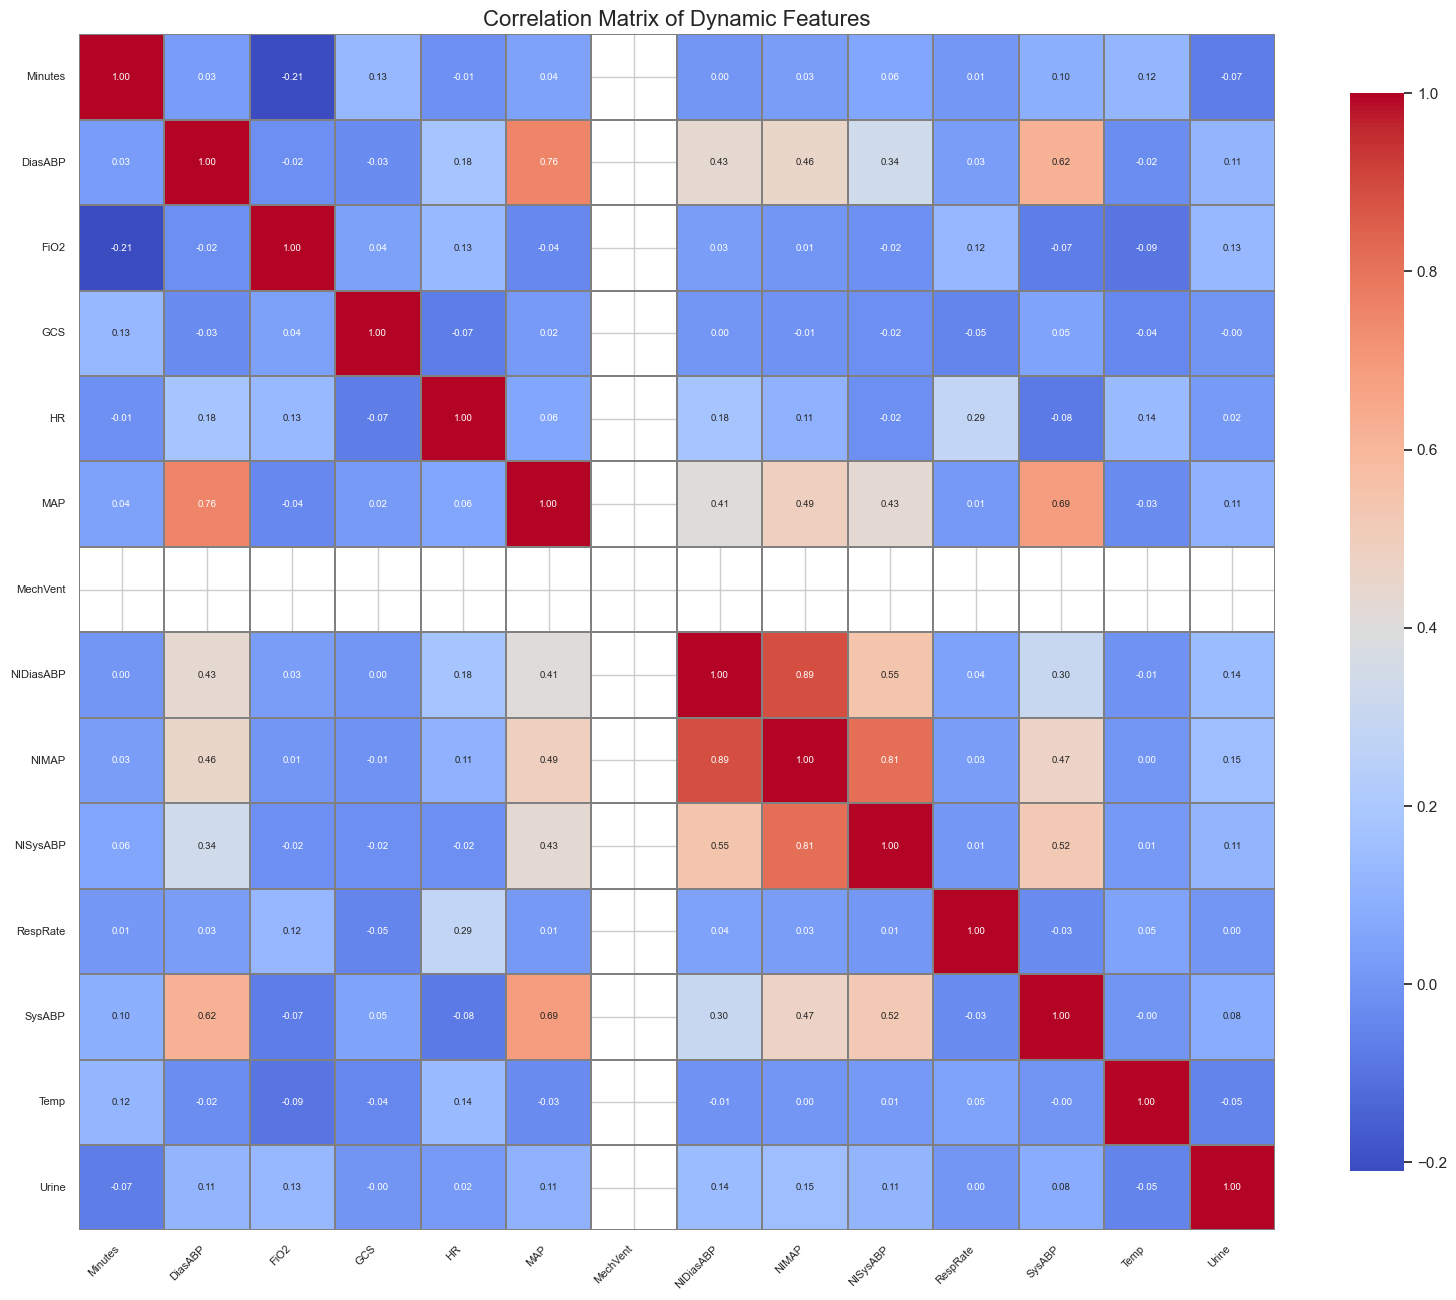

In [20]:
dynamic_features_df_corr = dynamic_features_df.copy()
dynamic_features_df_corr = dynamic_features_df_corr.drop(columns=['RecordID'])
cleaned_df = dynamic_features_df_corr.replace(-1, np.nan)
threshold = 0.9
valid_cols = cleaned_df.columns[cleaned_df.isna().mean() < threshold]
filtered_df = cleaned_df[valid_cols]

# Compute correlation 
correlation_matrix = filtered_df.corr(method='pearson', min_periods=10)

# Plot
plt.figure(figsize=(16, 14))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    cbar_kws={"shrink": .8},
    annot_kws={"size": 7},
    linewidths=0.3,
    linecolor='gray',
    mask=correlation_matrix.isnull()  
)

plt.title("Correlation Matrix of Dynamic Features", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()


## 7. Time Series Analysis

# Purpose: This section performs time series analysis on the dynamic features, focusing on trends and patterns over time for selected patients.

```python


### **Findings**

* **Heart Rate (HR)**:

  * Fairly stable between **60–90 bpm**.
  * No extreme tachycardia or bradycardia observed.

* **Respiratory Rate (RespRate)**:

  * Ranges from about **10 to 22 breaths/min**, with slight variability.
  * Appears to oscillate but mostly remains within normal physiological bounds.

* **Non-Invasive Mean Arterial Pressure (NIMAP)**:

  * Mostly in the **65–85 mmHg** range.
  * Slight dips and rises but no alarming hypotension or hypertension detected.

* **Temperature (Temp)**:

  * Stable between **36°C and 38°C**, indicating no significant fever or hypothermia.
  * Very low noise in measurement, possibly due to infrequent updates.

* **Urine Output**:

  * High variance and spikes, notably at time **0 hr (≈900 mL)** and another around **30 hr (≈450 mL)**.
  * Indicates possible **bolus fluid intake**, **diuretics**, or recovery from **renal hypoperfusion**.
  * Low values in some periods could signal **oliguria** or **monitoring gaps**.

---

###  **Actionable Insights**

* **Urine Output** should be monitored closely:

  * Wide fluctuations suggest potential **renal stress**, **fluid shifts**, or **therapeutic interventions**.
  * Recommend computing cumulative output to assess fluid balance.

* **HR and NIMAP are stable**:

  * Suggests cardiovascular parameters are well-maintained, no urgent need for intervention.

* **RespRate shows mild variability**:

  * May reflect patient response to care or early signs of respiratory instability.

* **Temp is not a concern**:

  * Can be deprioritized in high-frequency modeling unless sudden changes are detected across other patients.



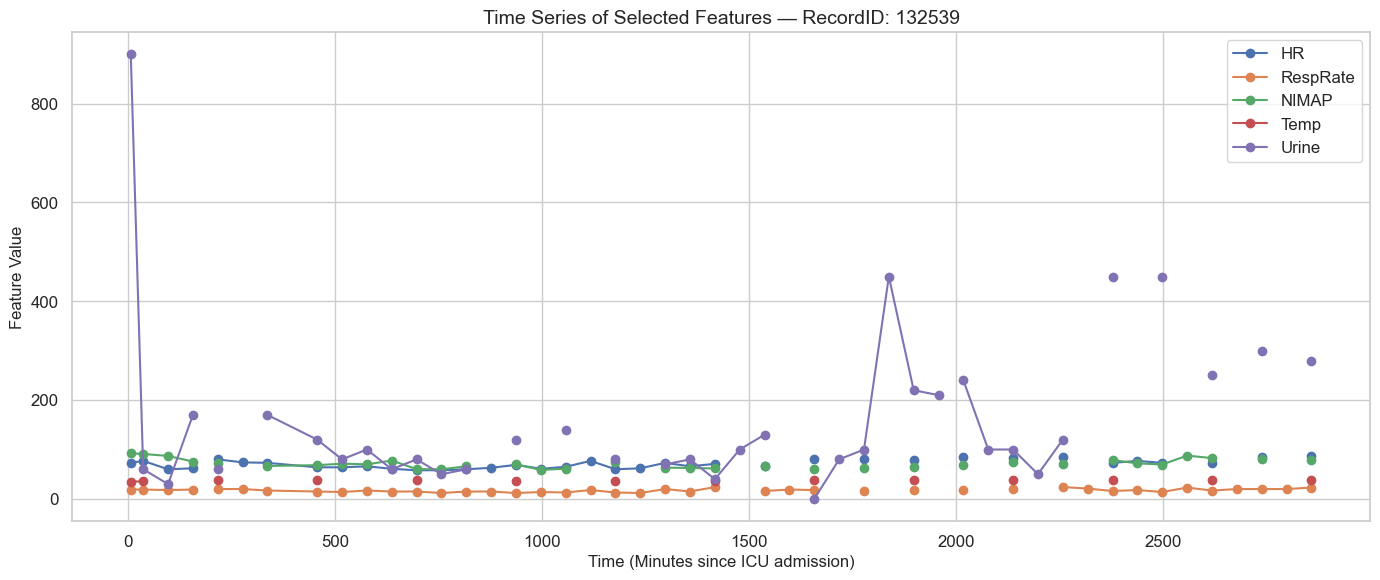

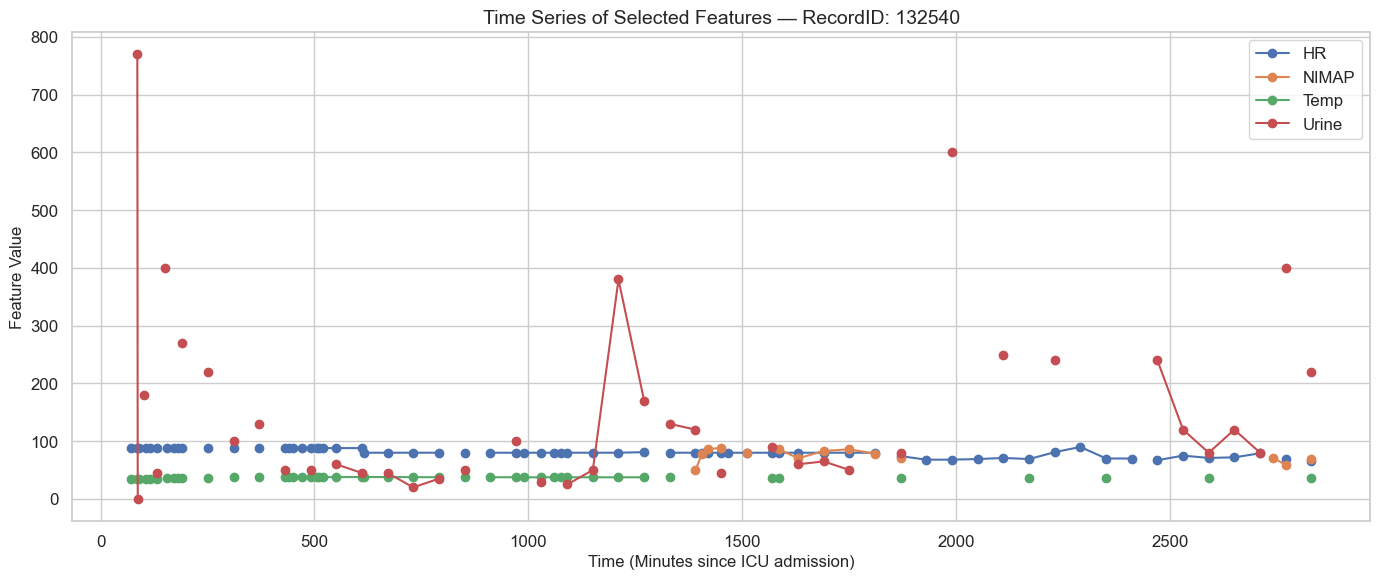

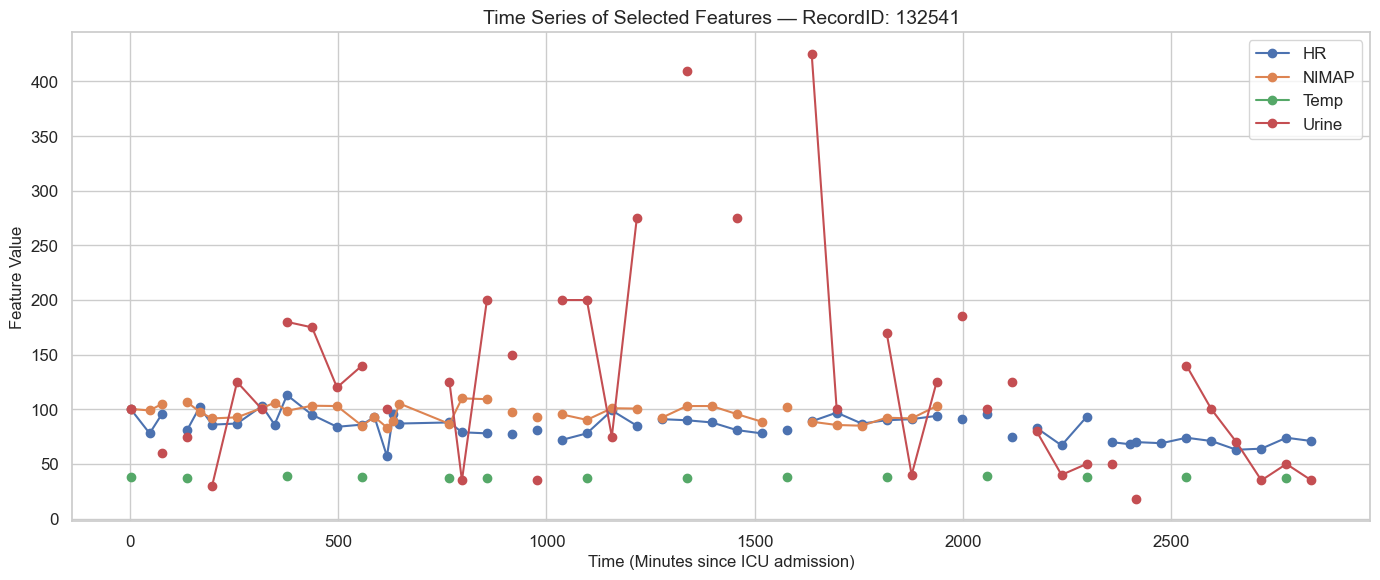

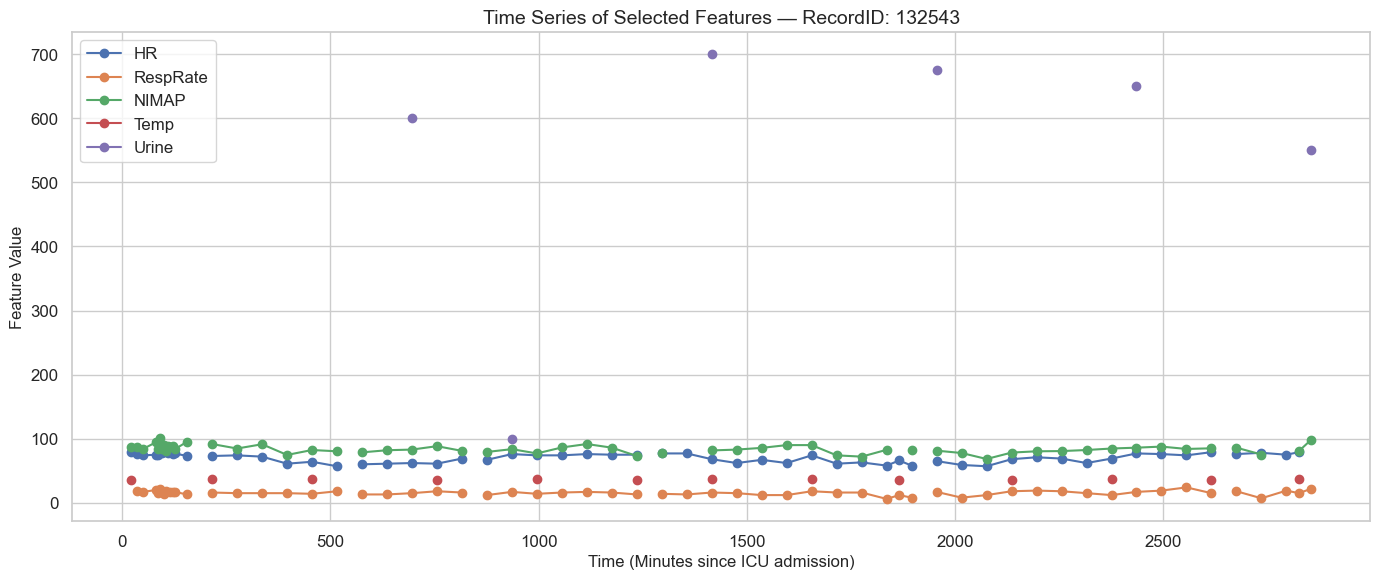

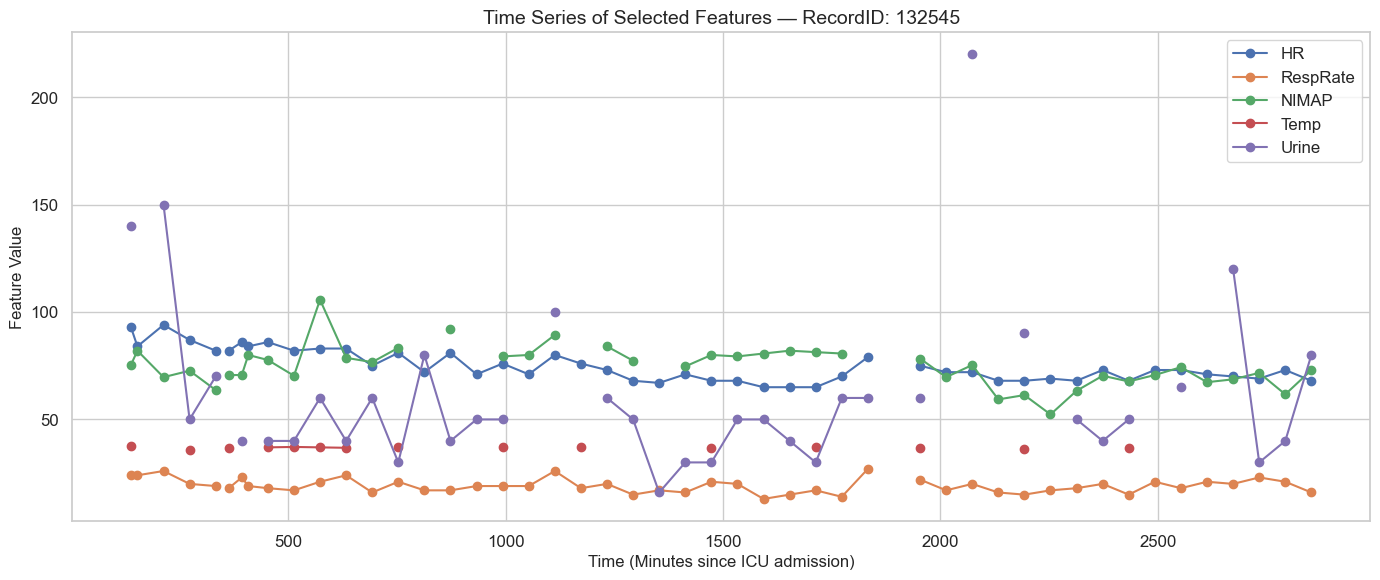

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Selected features based on correlation and clinical relevance
features_to_plot = ['HR', 'RespRate', 'NIMAP', 'Temp', 'Urine']

# Replace -1 with np.nan (missing values)
filtered_df = dynamic_features_df.copy()
filtered_df[features_to_plot] = filtered_df[features_to_plot].replace(-1, np.nan)

# Ensure correct sorting
filtered_df = filtered_df.sort_values(['RecordID', 'Minutes'])

# Select a few sample RecordIDs for visualization
sample_patients = filtered_df['RecordID'].dropna().unique()[:5]  

# Seaborn style
sns.set(style="whitegrid", font_scale=1.1)

# Plot time series per patient
for pid in sample_patients:
    patient_df = filtered_df[filtered_df['RecordID'] == pid]

    if patient_df.empty:
        continue  # Skip if no data

    plt.figure(figsize=(14, 6))
    for feature in features_to_plot:
        if feature in patient_df.columns and patient_df[feature].notna().any():
            plt.plot(
                patient_df['Minutes'], 
                patient_df[feature], 
                label=feature, 
                marker='o'
            )

    plt.title(f'Time Series of Selected Features — RecordID: {pid}', fontsize=14)
    plt.xlabel('Time (Minutes since ICU admission)', fontsize=12)
    plt.ylabel('Feature Value', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



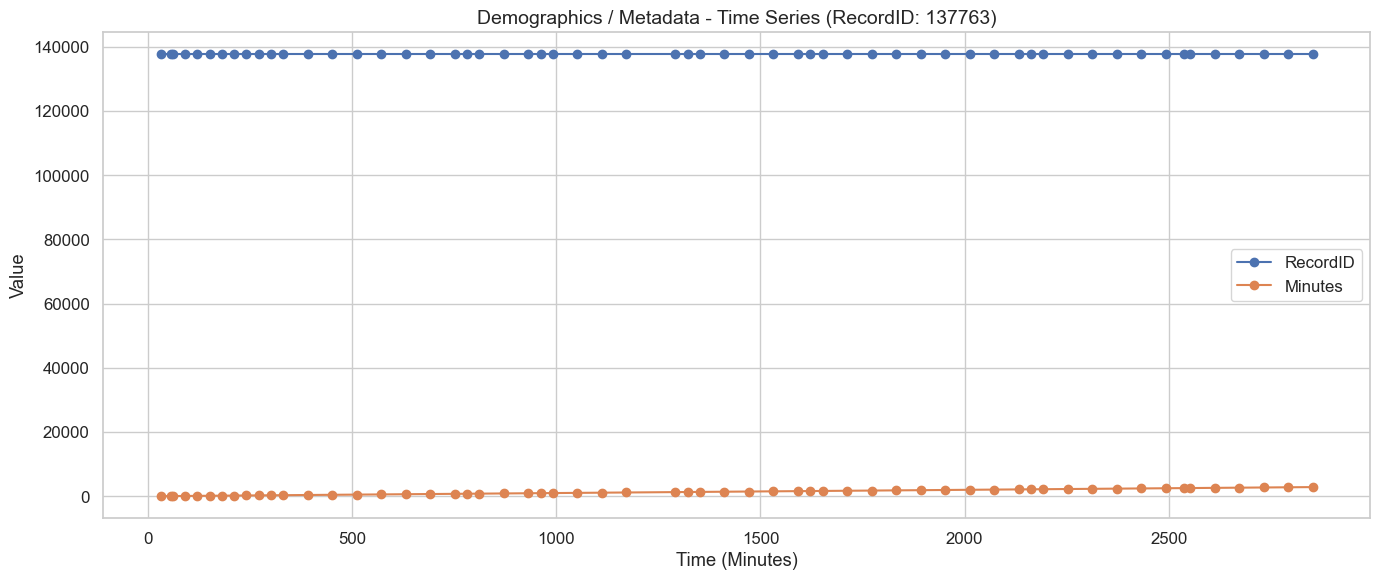

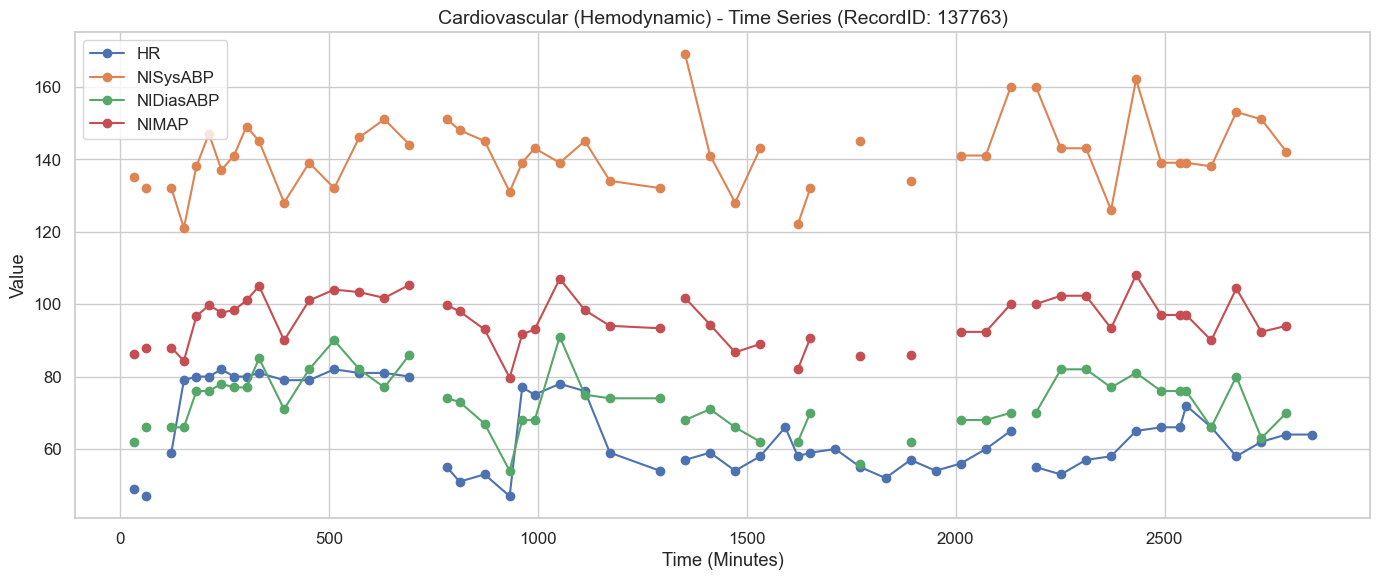

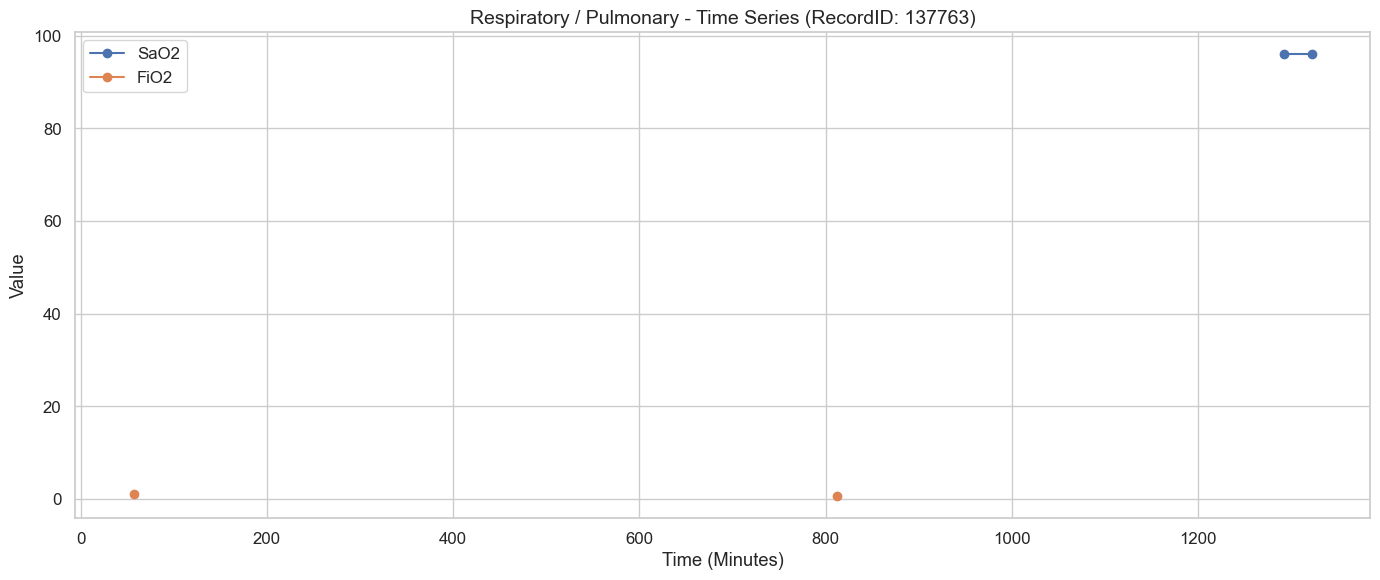

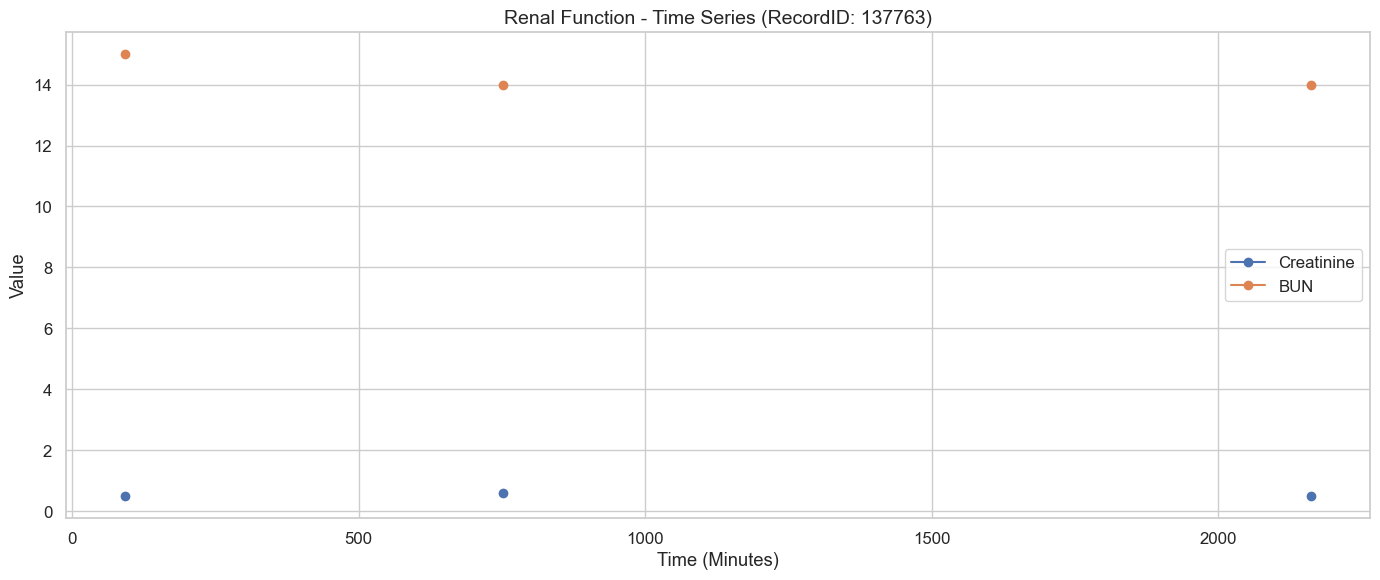

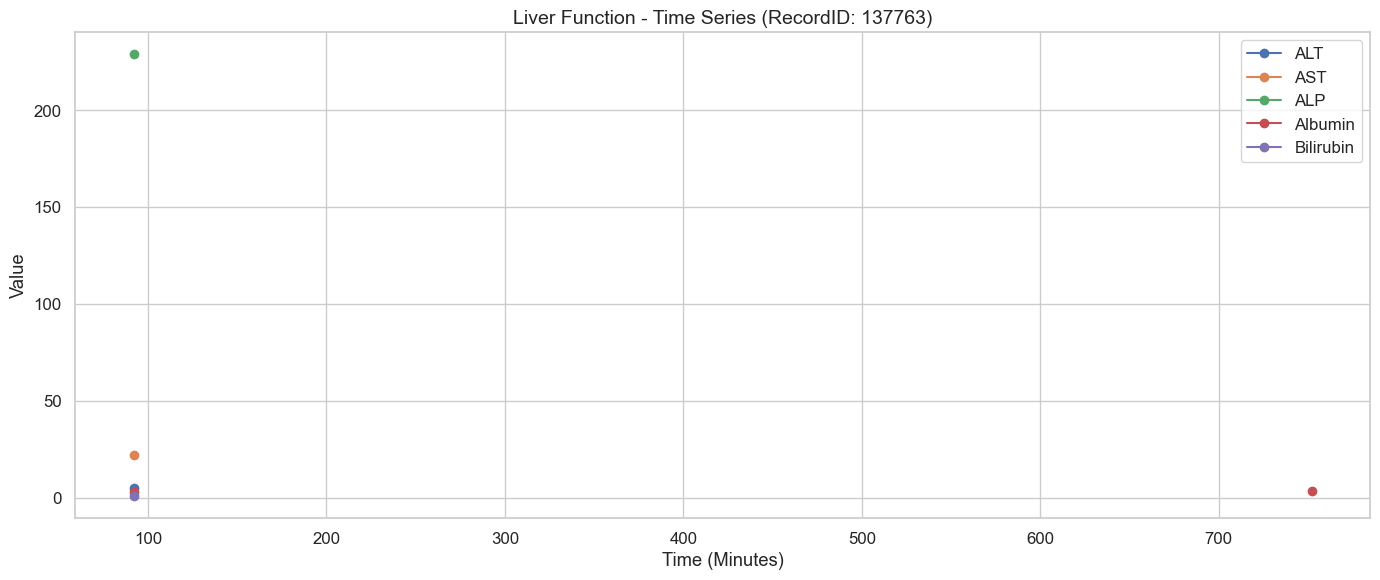

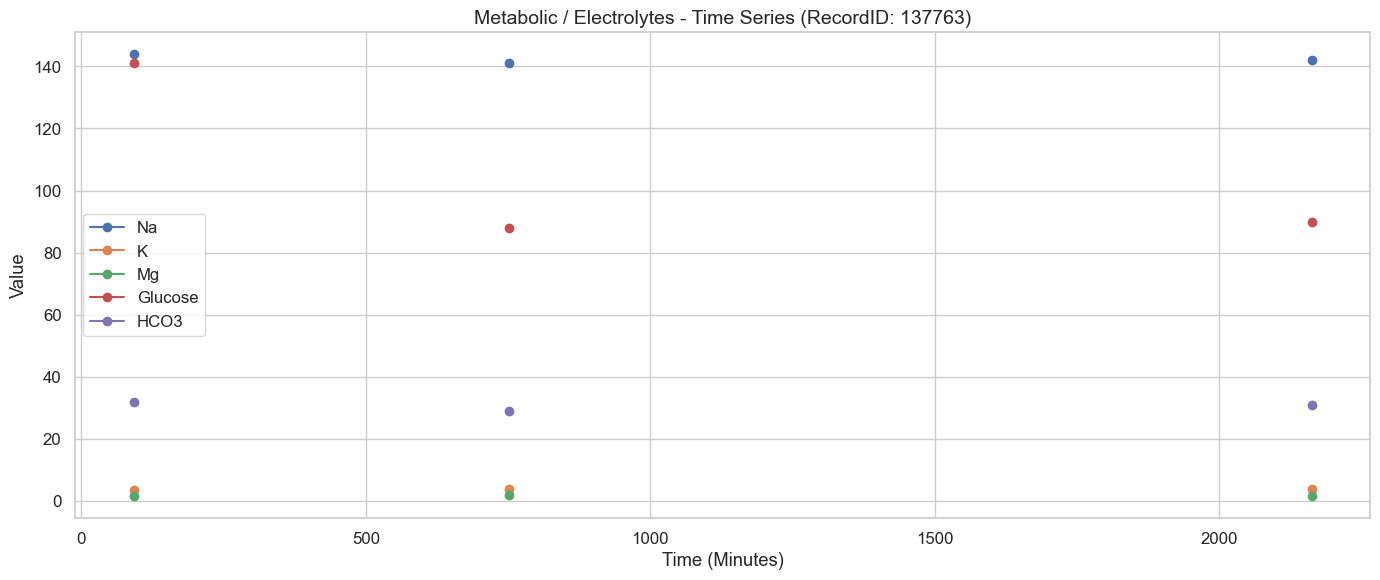

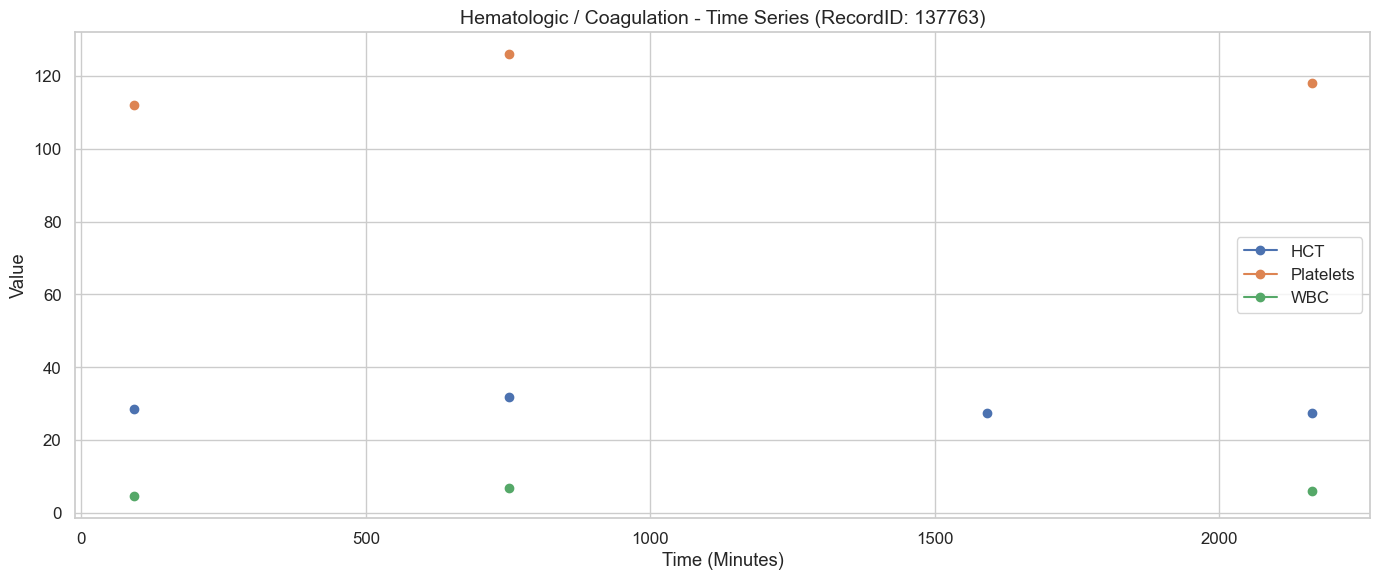

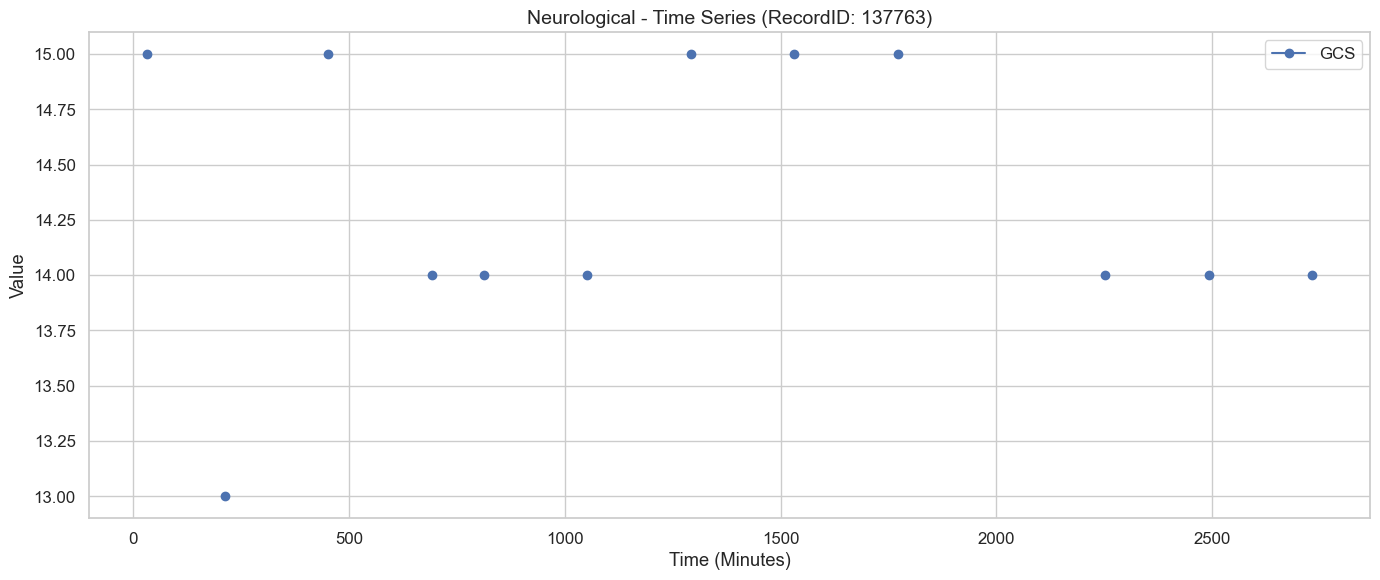

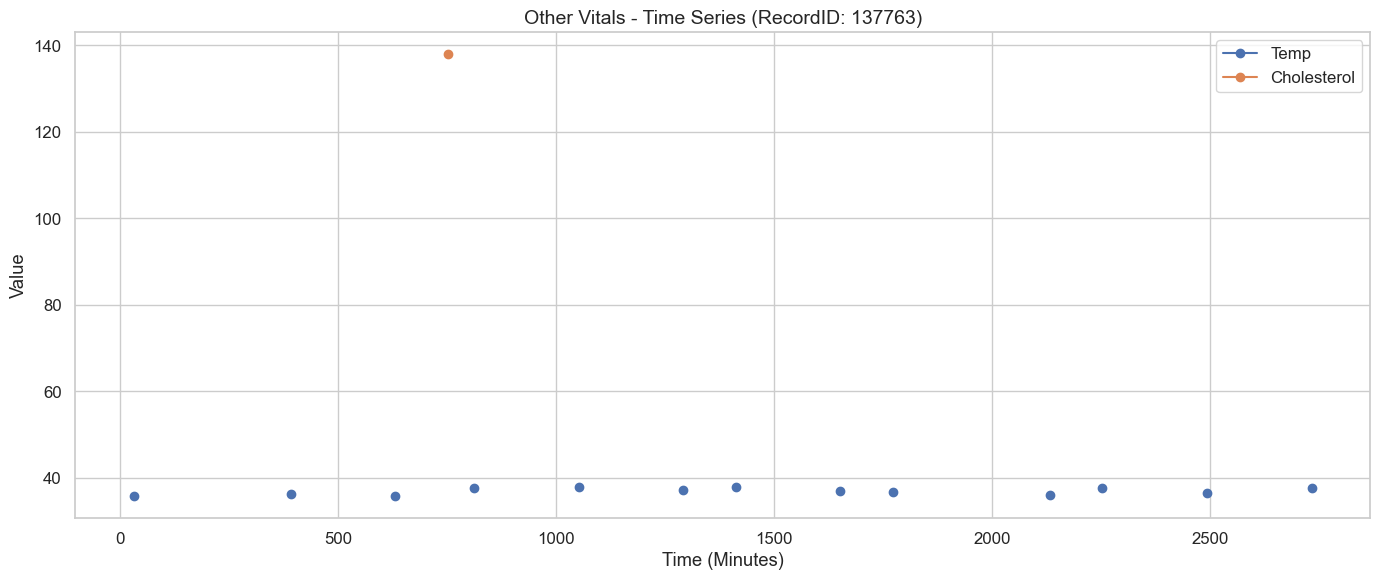

In [22]:
# Theme based visualization
theme_df = dynamic_features_df.replace(-1, np.nan)

# Seaborn styling
sns.set(style="whitegrid", font_scale=1.1)

# Pick a sample patient
sample_pid = theme_df['RecordID'].dropna().unique()[0]
patient_df = theme_df[theme_df['RecordID'] == sample_pid].sort_values('Minutes')

# Loop through each theme
for theme_name, features in themes.items():
    # Only keep features present in dataset
    valid_features = [f for f in features if f in patient_df.columns]
    
    if not valid_features:
        continue  # Skip if none found

    plt.figure(figsize=(14, 6))
    for feat in valid_features:
        if patient_df[feat].notna().any():
            plt.plot(patient_df['Minutes'], patient_df[feat], marker='o', label=feat)

    plt.title(f"{theme_name} - Time Series (RecordID: {sample_pid})", fontsize=14)
    plt.xlabel("Time (Minutes)")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
